---
title: 020 Exploratory Data Analysis, Processing, Feature Engineering
---

**Author**: Andrew Yew<br>
**Date**: 2023-04-11

Table of contents:
- [Notebook Introduction](#Notebook-Introduction)
- [Import Required Packages](#Import-Required-Packages)
- [Define Functions and Global Settings](#Define-Functions-and-Global-Settings)
- [Load Data](#Load-Data)
- [Extracting JSON Dictionary in `review_dict`](#Extracting-JSON-Dictionary-in-`review_dict`)
  - [Extracting `name`](#Extracting-`name`)
  - [Extracting Other Single Value Key-Value Pairs](#Extracting-Other-Single-Value-Key-Value-Pairs)
  - [Extract Review Text](#Extract-Review-Text)
  - [Extract Tags](#Extract-Tags)
  - [Extract Instructions](#Extract-Instructions)
  - [Extract Yield](#Extract-Yield)
  - [Extract Ingredients](#Extract-Ingredients)
  - [Extract Nutrition](#Extract-Nutrition)
  - [Extract Video](#Extract-Video)
  - [Extract Image](#Extract-Image)
  - [Extract Time Related Keys](#Extract-Time-Related-Keys)
  - [Extract Author](#Extract-Author)
  - [Extract Aggregate Rating](#Extract-Aggregate-Rating)
  - [Saving the Extracted JSON data](#Saving-the-Extracted-JSON-data)
- [Data Consolidation between Directly Scraped Data and Extracted JSON Data](#Data-Consolidation-between-Directly-Scraped-Data-and-Extracted-JSON-Data)
  - [Nutritional Information](#Nutritional-Information)
  - [Time Columns](#Time-Columns)
  - [Other Columns](#Other-Columns)
  - [Consolidated Data](#Consolidated-Data)
- [Exploratory Data Analysis and Feature Engineering](#Exploratory-Data-Analysis-and-Feature-Engineering)
  - [Target Feature: `average_rating`](#Target-Feature:-`average_rating`)
  - [Null Values](#Null-Values)
    - [Null Values for `number_of_reviews`](#Null-Values-for-`number_of_reviews`)
    - [Null Values for `number_of_servings`](#Null-Values-for-`number_of_servings`)
    - [Null Values for `cook_time` and `prep_time`](#Null-Values-for-`cook_time`-and-`prep_time`)
    - [Null Values for `tags`](#Null-Values-for-`tags`)
    - [Null Values for `review`](#Null-Values-for-`review`)
    - [Null Values for `author`](#Null-Values-for-`author`)
    - [Summary of Remaining Null Values](#Summary-of-Remaining-Null-Values)
    - [Removing Misrepresented Punctuation](#Removing-Misrepresented-Punctuation)
  - [Distribution Analysis](#Distribution-Analysis)
  - [Multicollinearity Analysis](#Multicollinearity-Analysis)
    - [Dropping collinear columns that cannot be transformed](#Dropping-collinear-columns-that-cannot-be-transformed)
  - [Feature Engineering](#Feature-Engineering)
  - [Reducing Bias towards Author](#Reducing-Bias-towards-Author)
- [Conclusion](#Conclusion)
- [Export Processed Data](#Export-Processed-Data)

# Notebook Introduction

This notebook builds on top of the previous notebook, '010 data acquisition', and details the exploratory data analysis, data processing, and feature engineering involved to prepare the data for modelling. The first step was to extract the data from the json dictionaries stored in the `review_text` column out into a DataFrame. Then the extracted values were compared with the values gathered directly during the scrape to determine which is a better source of data. Finally, exploratory data analysis and feature engineering was performed on the final chosen data.

# Import Required Packages

In [1]:
# Packages for processing data
import numpy as np
import pandas as pd

# Packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Package for pickling and loading pickle files.
import joblib
import time
import ast
import re
from tqdm.notebook import tqdm

# Package for statistical testing
from scipy import stats # chi-square test, pearson correlation test

# Define Functions and Global Settings

In [2]:
def categorical_value_count(df, col):
    '''
    Performs value counts for each catgory given a categorical column
    
    Usage
    -----
    Used throughout the notebook to understand the distribution of categorical variables and to confirm the ratio of the target variable.
    
    Input
    -----
    df  : DataFrame that contains the categorical column
    col : Categorical column to perform value counts on
    
    Output
    ------
    Prints a DataFrame that contains the categories, value counts for each category, and the % of total rows for each category
    
    Examples
    --------
    Given DataFrame 'df1' and categorical column 'col1':
    
    categorical_value_count(df1,'col1')
    
    '''
    # Creates a temporary DataFrame which stores the flatted value_count table generated by the value_counts method
    temp_df               = df[col].value_counts(dropna = False).rename_axis(col).reset_index(name = 'Counts')
    
    # Adds a new column which calculates the % of total for each row in the temporary DataFrame
    temp_df['% of total'] = round(temp_df['Counts']/df.shape[0]*100,2)
    
    # Return the DataFrame
    return temp_df

In [3]:
def plot_distribution(df, col):
    '''
    Plots 2 subplots: 
    Left subplot: histogram without any transformation. The mean and median lines were included.
    Right subplot: histogram with LOG transformation and on LOG scale. The mean and median lines were included.
    
    Usage
    -----
    Used in the EDA section to determine skewed distributions with outliers, and to determine if LOG should be applied to center skewed distributions and deal with outliers without dropping rows
    
    Input
    -----
    df  : DataFrame that contains the continuous numerical column
    col : Categorical column to plot distribution 
    
    Output
    ------
    Two subplots of histogram, left without transformation and right with LOG transformation
    
    Examples
    --------
    Given DataFrame 'df1' and categorical column 'col1':
    
    plot_distribution(df1,'col1')
    
    '''
    # Start timer
    start = time.perf_counter()
    print(f"===== Distribution Plots for {col} =====")
    
    # Create subplot object with 1 row and 2 columns
    plt.subplots(1, 2, figsize = (15,5))

    # Calculate the summary statistics for column
    col_mean = np.mean(df[col])
    col_median = np.median(df[col])

    # Plot first histogram to show distribution as is
    plt.subplot(1,2,1)
    sns.histplot(data = df, x = col, stat = 'probability');
    plt.axvline(col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(col_mean,2)}")
    plt.axvline(col_median, linestyle = '--', c = 'red', label = f"median: {np.round(col_median,2)}")
    plt.legend()
    plt.title(f"Distribution for {col}")

    # Plot second histogram to show log distribution
    # Calculate log of column
    log_df = np.log(df+1)
    log_col_mean = np.mean(log_df[col])
    log_col_median = np.median(log_df[col])

    # Plot second histogram to show LOG distribution
    plt.subplot(1,2,2)
    sns.histplot(data = log_df, x = col, stat = 'probability');
    plt.axvline(log_col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(log_col_mean,2)}")
    plt.axvline(log_col_median, linestyle = '--', c = 'red', label = f"median: {np.round(log_col_median,2)}")
    plt.xlabel(f"LOG {col}")
    plt.legend()
    plt.title(f"LOG Distribution for {col}")

    sns.despine()
    plt.show()
    
    # End timer 
    end = time.perf_counter()
    print(f"Time taken : {np.round(end - start,3)} seconds.")
    print(f"===============================================")
    print(f"")
    print(f"")

In [4]:
def extract_singular_values_from_json(df, col, key):
    """
    This function takes a DataFrame containing a colummn filled with JSON dictionaries 
    and extracts the value for the specified key.
    
    Rows that cause errors are left out.
    
    Input
    -----
    df: DataFrame containing JSON dictionaries
    col: column within DataFrame containing the JSON dictionaries
    key: JSON dictionary key for which to extact the value for
    
    Output
    ------
    temp_df: DataFrame containing extracted values from JSON dictionary
    error_list: list of errors during extraction if any.
    """
    
    # Initiate blank dictionary and lists 
    item_dict = {'row_index' : list(),
                 key : list()
                }
    error_list = list()
    error_count = 0

    # Looping through each row to gather the value for the specified key from JSON object
    for row_index, row in enumerate(tqdm(df.loc[:,col])):

        try:
            # Convert string entry into list containing JSON
            # Then select first item in list to access JSON dictionary
            json_dict = ast.literal_eval(row)[0]

            item_dict['row_index'].append(row_index)
            item_dict[key].append(json_dict[key])

        except:
            error_count += 1
            print(f"Errors: {error_count}, last error at {row_index}.", end='\r')
            error_list.append(row_index)
            continue
    
    # Convert dictionary into a DataFrame, then examine DataFrame
    temp_df = pd.DataFrame(item_dict).set_index('row_index')
    print(f"Errors: {error_count}, last error at {row_index}.")
    print(f"Number of extracted values {len(temp_df)}")
    display(temp_df.head())
    
    # Return DataFrame with extracted values
    return temp_df, error_list

In [71]:
def compare_columns(df1, df2, col1, col2):
    '''
    This function compares two columns from two DataFrammes, identifies rows of mismatches, then returns the matched DataFrame.
    
    Usage
    -----
    This function was mainly used to compare the JSON dictionary data vs directly web scraped data
    
    Input
    -----
    df1: First DataFrame to compare, usually the directly scraped data
    df2: Second DataFrame to compare, usually the JSON dictionary data
    col1: Column from first DataFrame to compare
    col2: Column from second DataFrame to compare
    
    Output
    ------
    df: a combined and compared df1, df2, col1, col2
    '''
    
    df = pd.merge(left  = df1[[col1]],
                  right = df2[[col2]],
                  left_index  = True,
                  right_index = True)
    df['equal'] = df[col1] == df[col2]
    print(f"Number of mismatches: {df[df['equal'] == False].shape[0]}")
    display(df[df['equal'] == False].head(5))
    return df

In [193]:
def plot_scatterplot(df, col1, col2):
    
    '''
    This function generates a scatter plot between the two variables
    
    Usage
    -----
    Used to examine collinear columns after a covariance matrix
    
    Input
    -----
    df: DataFrame containing the collinear columns
    col1: First column that is collinear with col2
    col2: Second column that is collinear with col1
    '''

    # Create a temporary variable to store the pearsonr results for tested variable
    pearsonr_temp = np.round(stats.pearsonr(df[col1],
                                            df[col2]),3)

    # Then a scatterplot between the independent variables were created with the correlation coefficients annotated.
    # Create figure object
    plt.figure(figsize = (5,5), dpi = 300)

    # Create scatterplot for two variables
    plt.scatter(x = df[col1],
                y = df[col2])

    # Setting figure labels and annotate with correlation factor and p-value
    plt.xlabel(f"{col1}")
    plt.ylabel(f"{col2}")
    plt.title(f"Scatterplot of {col1} vs {col2}\nCorrelation: {pearsonr_temp[0]} p-value: {pearsonr_temp[1]}")
    #plt.annotate(text = f"Correlation: {pearsonr_temp[0]}\np-value: {pearsonr_temp[1]}")
    sns.despine()
    plt.show()

# Load Data

In [5]:
raw_data_df = joblib.load('data/raw_data_df.pkl')

In [6]:
print(f"Shape of raw data: {raw_data_df.shape}.")

Shape of raw data: (40001, 18).


# Extracting JSON Dictionary in `review_dict`

The JSON dictionaries stored within the `review_dict` column during the web scrape was originally for just accessing review texts, but was discovered to contain more information that maybe helpful towards model training. As such, a recipe was chosen to be examined in detailed for each key-value pair within the JSON dictionary. 

In [7]:
# Print out sample of key value pairs available with JSON dictionary
# Recipe at index 40 was selected as it was a recipe with many ratings and reviews
recipe01 = ast.literal_eval(raw_data_df.loc[40,'review_dict'])[0]

print(f"Read below in format key_number : key")
for index, key in enumerate(recipe01.keys()):
    print(f"{index+1}, {key} : \n{recipe01[key]}\n\n\n")

Read below in format key_number : key
1, @context : 
http://schema.org



2, @type : 
['Recipe', 'NewsArticle']



3, headline : 
Authentic Louisiana Red Beans and Rice



4, datePublished : 
2019-04-03T23:31:28.000-04:00



5, dateModified : 
2023-01-24T20:09:13.640-05:00



6, author : 
[{'@type': 'Person', 'name': 'MIAMI BEACH', 'url': 'https://www.allrecipes.com/cook/765641'}]



7, description : 
This easy authentic Louisiana red beans and rice recipe features Cajun seasoning and andouille sausage for hearty, comforting flavor.



8, image : 
{'@type': 'ImageObject', 'url': 'https://www.allrecipes.com/thmb/yBmp-iPf9iRr7YHZadsZLUcGtPo=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/58211-Authentic-Louisiana-Red-Beans-and-Rice-mfs-STEP-001-ff46b545d9fa4dc290eb80bb4d523693.jpg', 'height': 1125, 'width': 1500}



9, video : 
{'@type': 'VideoObject', 'embedUrl': 'https://players.brightcove.net/1033249144001/default_default/index.html?videoId=6304526244001', 'description': 'L

Aside from written reviews, there appears to be a repeat of columns gathered directly during the webscrape. As an example, the directly scraped column `title` and the `name` column in the JSON dictionary above both express the same information: the title of the recipe. For now, the data for each of the relevant key value pairs in the JSON dictionary was extracted into DataFrames for further examination.

## Extracting `name`

In [8]:
# Create a blank DataFrame with the recipe indices to store extracted values:
json_data_df = raw_data_df[['review_dict']].copy().drop(columns = "review_dict")
json_data_df.head()

""
0
1
2
3
4


In [9]:
# Use predefined function to extract data from JSON dictionary
temp_df, temp_errors = extract_singular_values_from_json(raw_data_df,
                                                         'review_dict',
                                                         'name')

  0%|          | 0/40001 [00:00<?, ?it/s]

Errors: 7, last error at 40000.
Number of extracted values 39994


,name
row_index,
0,Corned Beef Roast
1,Stout-Braised Lamb Shanks
2,Chicken Al Pastor
3,Mississippi Chicken
4,Lasagna Flatbread


In [10]:
# Merge extracted data with DataFrame of extracted data using recipe indices
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1') # validate was used to ensure that only 1 extracted value was matched with 1 recipe

# Visually examine merge
display(json_data_df.head())

,name
0,Corned Beef Roast
1,Stout-Braised Lamb Shanks
2,Chicken Al Pastor
3,Mississippi Chicken
4,Lasagna Flatbread


## Extracting Other Single Value Key-Value Pairs

In [11]:
recipe01.keys()

dict_keys(['@context', '@type', 'headline', 'datePublished', 'dateModified', 'author', 'description', 'image', 'video', 'publisher', 'name', 'aggregateRating', 'cookTime', 'nutrition', 'prepTime', 'recipeIngredient', 'recipeInstructions', 'recipeYield', 'totalTime', 'review', 'mainEntityOfPage', 'about'])

In [12]:
keys_with_single_values = ['datePublished', 'dateModified', 'description']

for key in keys_with_single_values:
    # Use predefined function to extract data from JSON dictionary
    temp_df, temp_errors = extract_singular_values_from_json(raw_data_df,
                                                             'review_dict',
                                                              key)
    
    # Merge extracted data with DataFrame of extracted data using recipe indices
    json_data_df = pd.merge(json_data_df, 
                                 temp_df, 
                                 how = 'left', 
                                 left_index = True, 
                                 right_index = True,
                                 validate = '1:1') # validate was used to ensure that only 1 extracted value was matched with 1 recipe

  0%|          | 0/40001 [00:00<?, ?it/s]

Errors: 7, last error at 40000.
Number of extracted values 39994


,datePublished
row_index,
0,2019-04-02T02:47:19.000-04:00
1,2019-04-02T02:49:58.000-04:00
2,2022-12-01T12:36:07.000-05:00
3,2022-11-26T09:00:00.000-05:00
4,2016-10-13T00:27:31.000-04:00


  0%|          | 0/40001 [00:00<?, ?it/s]

Errors: 7, last error at 40000.
Number of extracted values 39994


,dateModified
row_index,
0,2023-02-08T15:58:38.000-05:00
1,2022-12-05T18:08:07.000-05:00
2,2022-12-01T12:36:07.000-05:00
3,2023-02-24T22:27:54.908-05:00
4,2022-11-10T18:23:19.000-05:00


  0%|          | 0/40001 [00:00<?, ?it/s]

Errors: 7, last error at 40000.
Number of extracted values 39994


,description
row_index,
0,Corned beef roast cooked in the oven for five ...
1,This hearty Irish lamb shank stew is perfect i...
2,This chicken al pastor features almost-charred...
3,Mississippi chicken recipe uses only 4 ingredi...
4,Give lasagna a quick and easy pizza makeover b...


In [13]:
# Visually examine the extracted data
display(json_data_df.head())

,name,datePublished,dateModified,description
0,Corned Beef Roast,2019-04-02T02:47:19.000-04:00,2023-02-08T15:58:38.000-05:00,Corned beef roast cooked in the oven for five ...
1,Stout-Braised Lamb Shanks,2019-04-02T02:49:58.000-04:00,2022-12-05T18:08:07.000-05:00,This hearty Irish lamb shank stew is perfect i...
2,Chicken Al Pastor,2022-12-01T12:36:07.000-05:00,2022-12-01T12:36:07.000-05:00,This chicken al pastor features almost-charred...
3,Mississippi Chicken,2022-11-26T09:00:00.000-05:00,2023-02-24T22:27:54.908-05:00,Mississippi chicken recipe uses only 4 ingredi...
4,Lasagna Flatbread,2016-10-13T00:27:31.000-04:00,2022-11-10T18:23:19.000-05:00,Give lasagna a quick and easy pizza makeover b...


In [14]:
# Generate a new feature for the word count of recipe name and description
json_data_df['name_wc'] = [len(str(name).split(' ')) for name in json_data_df['name'].tolist()]
json_data_df['description_wc'] = [len(str(desc).split(' ')) for desc in json_data_df['description'].tolist()]

# Converting string column to datetime with timezone as UTC
json_data_df['datePublished'] = pd.to_datetime(json_data_df['datePublished'], utc=True)
json_data_df['dateModified'] = pd.to_datetime(json_data_df['dateModified'], utc=True)

In [15]:
# Visually examine the new features and converted column types
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18


## Extract Review Text

The review text was extracted, then combined and stored as a single string for Natural Language Processing later on. Furthermore, as the reviews were extracted, numerical features such as review word count and the number of reviews were also generated

In [16]:
# Initiate blank dictionary and list for errors
temp_dict = {'recipe_index' : list(),
             'review' : list(),
             'review_wc' : list(),
             'number_of_review' : list()}
error_list = list()
error_count = 0 

# Iterate over each recipe
for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        # Access the review key value pair
        reviews = recipe_dict['review']
        
        # Initiate a blank string to store concatenated reviews
        temp_review = str()
        
        # Initiate zero for the word count of reviews
        temp_review_wc = 0
        
        # Iterate over each review within the recipe
        for review in reviews:
            # Concatenate the review into a single string
            temp_review += review['reviewBody'] + ' '
            
            # Perform a word count for the review, then add to total word count
            temp_review_wc += len(str(review['reviewBody']).split(' '))
        
        # Append extracted data back to blank dictionary
        temp_dict['review'].append(temp_review)
        temp_dict['number_of_review'].append(len(reviews))
        temp_dict['review_wc'].append(temp_review_wc)
        temp_dict['recipe_index'].append(recipe_index)
    
    
    except:
        # Print error messages if any
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [17]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0


As expected, all errors within the data extraction from the JSON dictionary were stored as null values. The errors encountered during data extraction were due to the recipe not having the dictionary key, which for the reviews column meant the recipe didn't have any written reviews yet. A similar procedure was repeated using different dictionary keys to extract all relevant data from the JSON dictionary.

## Extract Tags

In [18]:
temp_dict = {'recipe_index' : list(),
             'tags' : list()}
error_list = list()
error_count = 0 

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        breadcrumb = recipe_dict['mainEntityOfPage']['breadcrumb']['itemListElement']
        
        temp_tags = list()
        for i in range(0,len(breadcrumb)-1):
            temp_tag = breadcrumb[i]['item']['@id'].replace("https://www.allrecipes.com/recipe/","")\
                           .replace("https://www.allrecipes.com/recipes/","")
            temp_tag = re.sub(r"\d+", "", temp_tag)
            temp_tag = temp_tag.split("/")
            temp_tag = [tag for tag in temp_tag if tag != ""]
            temp_tags += temp_tag
            temp_tags = list(set(temp_tags))
        j = str()
        for i in temp_tags:
            j += i + ' '
        temp_dict['tags'].append(j)
        temp_dict['recipe_index'].append(recipe_index)
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [19]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread


## Extract Instructions

In [20]:
temp_dict = {'recipe_index' : list(),
             'recipeInstruction' : list(),
             'number_of_instruction' : list(),
             'instruction_wc' : list(),
             'instruction_has_image' : list()}

error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        instructions = str()
        instructions_wc = 0
        instructions_images = 0
        for i in recipe_dict['recipeInstructions']:
            instructions += i['text'] + ' '
            instructions_wc += len(str(i['text']).split(' '))
            if 'image' in i.keys():
                instructions_images += 1
            else:
                instructions_images += 0
        temp_dict['recipeInstruction'].append(instructions)
        temp_dict['instruction_wc'].append(instructions_wc)
        temp_dict['number_of_instruction'].append(len(recipe_dict['recipeInstructions']))
        if instructions_images>0:
            temp_dict['instruction_has_image'].append(1)
        else:
            temp_dict['instruction_has_image'].append(0)
        
        temp_dict['recipe_index'].append(recipe_index)
            
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [21]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,recipeInstruction,number_of_instruction,instruction_wc,instruction_has_image
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,Preheat the oven to 300 degrees F (150 degrees...,3.0,81.0,0.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,"Heat oil in a Dutch oven or large, wide pot ov...",4.0,161.0,0.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,Heat a skillet over medium-high heat. Add drie...,7.0,431.0,0.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,"Gather ingredients, and preheat the oven to 35...",4.0,78.0,1.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,Preheat oven to 375 degrees F (190 degrees C)....,5.0,81.0,0.0


## Extract Yield

In [22]:
temp_dict = {'recipe_index' : list(),
             'recipeYield' : list()}

error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        # Extracting all keys related to time in the dictionary
        temp_dict['recipeYield'].append(recipe_dict['recipeYield'][0])
        temp_dict['recipe_index'].append(recipe_index)
            
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [23]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,recipeInstruction,number_of_instruction,instruction_wc,instruction_has_image,recipeYield
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,Preheat the oven to 300 degrees F (150 degrees...,3.0,81.0,0.0,8
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,"Heat oil in a Dutch oven or large, wide pot ov...",4.0,161.0,0.0,4
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,Heat a skillet over medium-high heat. Add drie...,7.0,431.0,0.0,10
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,"Gather ingredients, and preheat the oven to 35...",4.0,78.0,1.0,4
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,Preheat oven to 375 degrees F (190 degrees C)....,5.0,81.0,0.0,6


## Extract Ingredients

In [24]:
temp_dict = {'recipe_index' : list(),
             'recipeIngredient' : list(),
             'number_of_ingredient' : list()}
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        # Extracting all keys related to time in the dictionary
        temp_dict['number_of_ingredient'].append(len(recipe_dict['recipeIngredient']))
        
        j = str()
        for i in recipe_dict['recipeIngredient']:
            j += i + ' '
        temp_dict['recipeIngredient'].append(j)
        temp_dict['recipe_index'].append(recipe_index)
            
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [25]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,recipeInstruction,number_of_instruction,instruction_wc,instruction_has_image,recipeYield,recipeIngredient,number_of_ingredient
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,Preheat the oven to 300 degrees F (150 degrees...,3.0,81.0,0.0,8,1 (5 1/2 pound) corned beef brisket with spice...,5.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,"Heat oil in a Dutch oven or large, wide pot ov...",4.0,161.0,0.0,4,1 tablespoon vegetable oil 4 lamb shanks 1 oni...,14.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,Heat a skillet over medium-high heat. Add drie...,7.0,431.0,0.0,10,"4 dried guajillo chiles, stemmed and seeded 2 ...",16.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,"Gather ingredients, and preheat the oven to 35...",4.0,78.0,1.0,4,"2 pounds skinless, boneless chicken breasts 1 ...",4.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,Preheat oven to 375 degrees F (190 degrees C)....,5.0,81.0,0.0,6,1 (15 ounce) container ricotta cheese 1 (8 oun...,8.0


## Extract Nutrition

In [26]:
temp_dict = {'recipe_index' : list(),
             'nutrition_key'     : list(),
             'nutrition_value'   : list()}

error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]

        # Extracting all keys related to time in the dictionary
        keys_related_to_nutrition = recipe_dict['nutrition'].keys()

        for key in keys_related_to_nutrition:
            temp_dict['recipe_index'].append(recipe_index)
            temp_dict['nutrition_key'].append(key)
            temp_dict['nutrition_value'].append(recipe_dict['nutrition'][key])
            
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [29]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

In [30]:
# Examine the extracted nutrition information
display(temp_df.head())

,nutrition_key,nutrition_value
recipe_index,,
0,@type,NutritionInformation
0,calories,465 kcal
0,carbohydrateContent,28 g
0,cholesterolContent,134 mg
0,fiberContent,4 g


The value of the nutrition and its unit are attached together under 'nutrition_value'. The Pandas split method was used to separate the values and the units into separate columns.

In [31]:
# Split unit and values into separate columns
temp_df['unit'] = temp_df['nutrition_value'].str.split(' ',expand = True)[1]
temp_df['nutrition_value'] = temp_df['nutrition_value'].str.split(' ',expand = True)[0]

In [32]:
# Explore distribution of categories within 'nutrition_key'
categorical_value_count(temp_df, 'nutrition_key')

,nutrition_key,Counts,% of total
0,@type,39414,9.37
1,unsaturatedFatContent,39414,9.37
2,calories,39406,9.37
3,sodiumContent,39377,9.36
4,carbohydrateContent,39353,9.35
5,proteinContent,39122,9.30
6,fatContent,38769,9.22
7,fiberContent,37884,9.01
8,saturatedFatContent,37351,8.88
9,sugarContent,37235,8.85


The `@type` nutrition key seems to be just a placeholder for the text 'NutritionInformation'. The servingSize nutrition key appears to be mostly null values since only 933 were specified for 40,001 recipes. Thus, these two columns were dropped.

In [33]:
# Dropping the two columns
temp_df = temp_df[~temp_df['nutrition_key'].isin(['@type', 'servingSize'])].copy()

In [34]:
# Checking if each nutritition key has one unit
temp_df[['nutrition_key','unit']].value_counts().sort_index()

nutrition_key          unit
calories               kcal    39406
carbohydrateContent    g       39352
                       mg          1
cholesterolContent     mg      32416
fatContent             g       38769
fiberContent           g       37884
proteinContent         g       39122
saturatedFatContent    g       37351
sodiumContent          mg      39377
sugarContent           g       37235
unsaturatedFatContent  g       39414
dtype: int64

Only 1 row of 'carbohydrateContent' had a different unit of mg. Given that it was just 1 row, that specific row was dropped.

In [35]:
# Dropping row where nutrition_key is carbohydrateContentt and unit is mg
temp_df = temp_df[~((temp_df['nutrition_key'] == 'carbohydrateContent') & 
                    (temp_df['unit'] == 'mg'))].copy()

Then, the unit was combined with the nutrition_key. This was performed so that the DataFrame can be pivoted so that each row is one recipe and the columns represent nutritional value.

In [36]:
# Combine nutrition_key with unit
temp_df['nutrition_key'] = temp_df['nutrition_key'] + '_' + temp_df['unit']
temp_df.drop(columns = ['unit'], inplace = True)

# Convert data type to float
temp_df['nutrition_value'] = temp_df['nutrition_value'].astype(float)

In [37]:
# Pivot the DataFrame so that each row is 1 recipe and the columns are nutritional information
temp_df = temp_df.reset_index().pivot(index = 'recipe_index', 
                                      columns = 'nutrition_key', 
                                      values = 'nutrition_value')

In [38]:
# Visually examine the pivoted DataFrame
display(temp_df.head())

nutrition_key,calories_kcal,carbohydrateContent_g,cholesterolContent_mg,fatContent_g,fiberContent_g,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g
recipe_index,,,,,,,,,,
0,465.0,28.0,134.0,26.0,4.0,28.0,9.0,1560.0,2.0,0.0
1,348.0,16.0,89.0,15.0,3.0,30.0,5.0,544.0,5.0,0.0
2,324.0,31.0,113.0,10.0,4.0,28.0,2.0,422.0,NaN,0.0
3,393.0,7.0,162.0,15.0,1.0,54.0,8.0,3002.0,NaN,0.0
4,602.0,31.0,134.0,37.0,11.0,44.0,16.0,1679.0,6.0,0.0


Visual inspection revealed that the transformation went as expected. By default setting of allrecipes.com recipes, nutritional values are all for 1 serving of food, where the definition of a serving is still up to the individual recipe author. Finally, the pivoted table was rejoined with json_data_df.

In [39]:
# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,calories_kcal,carbohydrateContent_g,cholesterolContent_mg,fatContent_g,fiberContent_g,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,465.0,28.0,134.0,26.0,4.0,28.0,9.0,1560.0,2.0,0.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,348.0,16.0,89.0,15.0,3.0,30.0,5.0,544.0,5.0,0.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,324.0,31.0,113.0,10.0,4.0,28.0,2.0,422.0,NaN,0.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,393.0,7.0,162.0,15.0,1.0,54.0,8.0,3002.0,NaN,0.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,602.0,31.0,134.0,37.0,11.0,44.0,16.0,1679.0,6.0,0.0


## Extract Video

In [46]:
temp_dict = {'recipe_index' : list(),
             'has_video' : list()
                }
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):

    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]

        #temp_dict['video_url'].append(recipe_dict['video']['embedUrl'])
        if 'video' in recipe_dict.keys():
            temp_dict['has_video'].append(1)
        else:
            temp_dict['has_video'].append(0)
        temp_dict['recipe_index'].append(recipe_index)


    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [47]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,carbohydrateContent_g,cholesterolContent_mg,fatContent_g,fiberContent_g,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g,has_video
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,28.0,134.0,26.0,4.0,28.0,9.0,1560.0,2.0,0.0,0.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,16.0,89.0,15.0,3.0,30.0,5.0,544.0,5.0,0.0,0.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,31.0,113.0,10.0,4.0,28.0,2.0,422.0,NaN,0.0,0.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,7.0,162.0,15.0,1.0,54.0,8.0,3002.0,NaN,0.0,0.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,31.0,134.0,37.0,11.0,44.0,16.0,1679.0,6.0,0.0,0.0


## Extract Image

In [48]:
temp_dict = {'recipe_index' : list(),
             'has_image' : list()
            }
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):

    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]
        
        if 'image' in recipe_dict.keys():
            temp_dict['has_image'].append(1)
        else:
            temp_dict['has_image'].append(0)

        temp_dict['recipe_index'].append(recipe_index)

    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [49]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,cholesterolContent_mg,fatContent_g,fiberContent_g,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g,has_video,has_image
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,134.0,26.0,4.0,28.0,9.0,1560.0,2.0,0.0,0.0,1.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,89.0,15.0,3.0,30.0,5.0,544.0,5.0,0.0,0.0,1.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,113.0,10.0,4.0,28.0,2.0,422.0,NaN,0.0,0.0,1.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,162.0,15.0,1.0,54.0,8.0,3002.0,NaN,0.0,0.0,1.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,134.0,37.0,11.0,44.0,16.0,1679.0,6.0,0.0,0.0,1.0


## Extract Time Related Keys

In [50]:
# Initiate blank dictionaries and lists 
temp_dict = {'recipe_index' : list(),
             'time_key'     : list(),
             'time_value'   : list()}
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):
    
    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]

        # Extracting all keys related to time in the dictionary
        keys_related_to_time = [key for key in recipe_dict.keys() if key[-4:] == 'Time']

        for key in keys_related_to_time:
            temp_dict['recipe_index'].append(recipe_index)
            temp_dict['time_key'].append(key)
            temp_dict['time_value'].append(recipe_dict[key])
            
    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

  0%|          | 0/40001 [00:00<?, ?it/s]

In [52]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

display(temp_df.head())

,time_key,time_value
recipe_index,,
0,cookTime,PT300M
0,prepTime,PT15M
0,totalTime,PT315M
1,cookTime,PT145M
1,prepTime,PT25M


The time values are stored as a combination of numbers and strings. It appears all values were stored as minutes. Regular expression was used to extract the numerical minutes from the mixed text. Finally, similar to nutrition, tha DataFrame was pivoted so that each recipe is one row.

In [55]:
# Removing all text and converting to integer
temp_df['time_value'] = temp_df['time_value'].str.extract('(\d+)').astype(int)
temp_df.reset_index(inplace = True)

In [56]:
# Pivoting each time key into separate columns
temp_df = temp_df.pivot(index = 'recipe_index', 
                        columns = 'time_key', 
                        values = 'time_value')

display(temp_df.head())

time_key,cookTime,prepTime,totalTime
recipe_index,,,
0,300.0,15.0,315.0
1,145.0,25.0,170.0
2,90.0,NaN,610.0
3,NaN,5.0,100.0
4,15.0,25.0,40.0


Visually, only 3 types of time were specified. Although cookTime and prepTime should add up to totalTime, this was not the case as some recipes had other times like marination time and fermentation time. However, it seems that only these three types of time were universally captured for all recipes.

In [57]:
# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,proteinContent_g,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g,has_video,has_image,cookTime,prepTime,totalTime
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,28.0,9.0,1560.0,2.0,0.0,0.0,1.0,300.0,15.0,315.0
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,30.0,5.0,544.0,5.0,0.0,0.0,1.0,145.0,25.0,170.0
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,28.0,2.0,422.0,NaN,0.0,0.0,1.0,90.0,NaN,610.0
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,54.0,8.0,3002.0,NaN,0.0,0.0,1.0,NaN,5.0,100.0
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,44.0,16.0,1679.0,6.0,0.0,0.0,1.0,15.0,25.0,40.0


## Extract Author

In [58]:
temp_dict = {'recipe_index' : list(),
             'author' : list()
                }
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):

    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]

        temp_dict['author'].append(recipe_dict['author'][0]['name'])
        temp_dict['recipe_index'].append(recipe_index)


    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

  0%|          | 0/40001 [00:00<?, ?it/s]

In [59]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,saturatedFatContent_g,sodiumContent_mg,sugarContent_g,unsaturatedFatContent_g,has_video,has_image,cookTime,prepTime,totalTime,author
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,9.0,1560.0,2.0,0.0,0.0,1.0,300.0,15.0,315.0,LUVNGMOM
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,5.0,544.0,5.0,0.0,0.0,1.0,145.0,25.0,170.0,Nick Russell
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,2.0,422.0,NaN,0.0,0.0,1.0,90.0,NaN,610.0,Melissa Gray
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,8.0,3002.0,NaN,0.0,0.0,1.0,NaN,5.0,100.0,Allrecipes Editorial Team
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,16.0,1679.0,6.0,0.0,0.0,1.0,15.0,25.0,40.0,apk979


## Extract Aggregate Rating

In [60]:
temp_dict = {'recipe_index' : list(),
             'ratingValue' : list(),
             'ratingCount' : list()
                }
error_list = list()
error_count = 0

for recipe_index, recipe in enumerate(tqdm(raw_data_df.loc[:,'review_dict'])):

    try:
        # Convert string entry into list, then dictionary
        recipe_dict = ast.literal_eval(recipe)[0]

        temp_dict['ratingValue'].append(recipe_dict['aggregateRating']['ratingValue'])
        temp_dict['ratingCount'].append(recipe_dict['aggregateRating']['ratingCount'])
        temp_dict['recipe_index'].append(recipe_index)


    except:
        error_count += 1
        print(f"Errors: {error_count}, last error at {recipe_index}.", end='\r')
        error_list.append(recipe_index)
        continue

temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

  0%|          | 0/40001 [00:00<?, ?it/s]

In [61]:
# Store dictionary as DataFrame for joining
temp_df = pd.DataFrame(temp_dict).set_index('recipe_index')

# Merge extracted data with DataFrame of extracted data
json_data_df = pd.merge(json_data_df, 
                             temp_df, 
                             how = 'left', 
                             left_index = True, 
                             right_index = True,
                             validate = '1:1')

# Examine merged DataFrame
display(json_data_df.head())

,name,datePublished,dateModified,description,name_wc,description_wc,review,review_wc,number_of_review,tags,...,sugarContent_g,unsaturatedFatContent_g,has_video,has_image,cookTime,prepTime,totalTime,author,ratingValue,ratingCount
0,Corned Beef Roast,2019-04-02 06:47:19+00:00,2023-02-08 20:58:38+00:00,Corned beef roast cooked in the oven for five ...,3,26,"Big corned beef fan, Great alternative to boil...",2696.0,54.0,corned-beef main-dish beef,...,2.0,0.0,0.0,1.0,300.0,15.0,315.0,LUVNGMOM,4.4,68
1,Stout-Braised Lamb Shanks,2019-04-02 06:49:58+00:00,2022-12-05 23:08:07+00:00,This hearty Irish lamb shank stew is perfect i...,3,21,Awesome. Though I thought it could use a bit (...,1375.0,39.0,european uk-and-ireland world-cuisine irish,...,5.0,0.0,0.0,1.0,145.0,25.0,170.0,Nick Russell,4.5,45
2,Chicken Al Pastor,2022-12-01 17:36:07+00:00,2022-12-01 17:36:07+00:00,This chicken al pastor features almost-charred...,3,17,NaN,NaN,NaN,world-cuisine latin-american main-dishes mexic...,...,NaN,0.0,0.0,1.0,90.0,NaN,610.0,Melissa Gray,5,1
3,Mississippi Chicken,2022-11-26 14:00:00+00:00,2023-02-25 03:27:54.908000+00:00,Mississippi chicken recipe uses only 4 ingredi...,2,19,Very different. Since my hubby loves peperonci...,80.0,4.0,meat-and-poultry chicken,...,NaN,0.0,0.0,1.0,NaN,5.0,100.0,Allrecipes Editorial Team,4.8,4
4,Lasagna Flatbread,2016-10-13 04:27:31+00:00,2022-11-10 23:23:19+00:00,Give lasagna a quick and easy pizza makeover b...,2,18,Delicious as pan Lasagna but so much easier on...,776.0,31.0,bread quick-bread,...,6.0,0.0,0.0,1.0,15.0,25.0,40.0,apk979,4.5,42


## Saving the Extracted JSON data

In [62]:
json_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40001 entries, 0 to 40000
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   name                     39994 non-null  object             
 1   datePublished            39994 non-null  datetime64[ns, UTC]
 2   dateModified             39994 non-null  datetime64[ns, UTC]
 3   description              39994 non-null  object             
 4   name_wc                  40001 non-null  int64              
 5   description_wc           40001 non-null  int64              
 6   review                   36042 non-null  object             
 7   review_wc                36042 non-null  float64            
 8   number_of_review         36042 non-null  float64            
 9   tags                     39994 non-null  object             
 10  recipeInstruction        39992 non-null  object             
 11  number_of_instruction    399

In [69]:
print(f"Number of numerical columns: {json_data_df.select_dtypes('number').shape[1]}.")
print(f"Number of text columns: {json_data_df.select_dtypes(object).shape[1]}.")
print(f"Number of date columns: {json_data_df.select_dtypes(exclude = [object, 'number']).shape[1]}.")

Number of numerical columns: 23.
Number of text columns: 10.
Number of date columns: 2.


In [70]:
# Store the extracted data
joblib.dump(json_data_df, 'data/json_data_df.pkl')

['data/json_data_df.pkl']

# Data Consolidation between Directly Scraped Data and Extracted JSON Data

To recap, thus far there was only one data source: directly web scraping from the web. However, the `review_dict` column, also scraped from the web, was a JSON dictionary containing possibly duplicate information such as recipe title and ingredients. Thus, there was a need to determine which source of data, either directly web scraping or extracting from the JSON dictionary within the `review_dict` column, was the best for this project.

To this end, comparisons were made between columns representing similar information from the two sources. The format of headers below can be understood as directly web scraped on the left and extracted from JSON dictionary on the right.

In [73]:
# raw_data_df represents the data directly scraped from the web
raw_data_df.head(1).T

,0
recipe_url,https://www.allrecipes.com/recipe/83646/corned...
title,Corned Beef Roast
image,['https://imagesvc.meredithcorp.io/v3/mm/image...
rating_average,4.4
rating_count,68
review_count,54 Reviews
description,This corned beef roast is easy to prepare and ...
update_date,"Updated on February 8, 2023"
ingredient,['1 (5 1/2 pound) corned beef brisket with spi...
direction,['Preheat the oven to 300 degrees F (150 degre...


In [75]:
# A blank DataFrame was created to store the consolidated data
consolidated_df = pd.DataFrame()

## `title` vs `name`

In [74]:
temp_df = compare_columns(raw_data_df,json_data_df,'title','name')

Number of mismatches: 3416


,title,name,equal
10,World's Best Lasagna,World&#39;s Best Lasagna,False
17,Chef John's Perfect Prime Rib,Chef John&#39;s Perfect Prime Rib,False
28,Marie's Easy Slow Cooker Pot Roast,Marie&#39;s Easy Slow Cooker Pot Roast,False
33,Chef John's Italian Meatballs,Chef John&#39;s Italian Meatballs,False
53,Campbell's Tuna Noodle Casserole,Campbell&#39;s Tuna Noodle Casserole,False


It appears that the recipe titles extracted from the JSON dictionary do not have punctuation expressed in a human legible format. Thus, the column scraped directly was used.

In [76]:
# Add selected column to consolidated DataFrame
consolidated_df['recipe_title'] = raw_data_df['title']

# drop the consolidated columns
raw_data_df.drop(columns = ['title'], 
                 inplace = True)
json_data_df.drop(columns = ['name'],
                     inplace = True)

## `rating_average` vs `ratingValue`

In [81]:
# Convert data type from object to float
json_data_df['ratingValue'] = json_data_df['ratingValue'].astype(float)

# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'rating_average','ratingValue')

Number of mismatches: 4351


,rating_average,ratingValue,equal
23,4.8,4.9,False
30,4.8,4.9,False
36,4.8,4.9,False
55,4.8,4.9,False
99,4.8,4.9,False


In [83]:
# Further examining all unique combinations of mismatches
temp_df[temp_df['equal'] == False].drop_duplicates(subset = ['rating_average','ratingValue'])

,rating_average,ratingValue,equal
23,4.8,4.9,False
123,NaN,NaN,False
230,4.3,4.4,False
370,4.4,4.5,False
1432,4.9,5.0,False
1590,3.8,3.9,False
1701,3.3,3.4,False
2149,3.5,3.6,False
35882,2.5,2.6,False


The average ratings extracted from the JSON dictionary were slightly higher than the ratings extracted from the initial scrape. The uniform difference of 0.1 suggests it was caused by a difference in rounding logic. Given that access to all rating scores was not available, the more conservative `rating_average` from directly web scraping was used.

In [84]:
# Add selected column to consolidated DataFrame
consolidated_df['average_rating'] = raw_data_df['rating_average']

# drop the consolidated columns
raw_data_df.drop(columns = ['rating_average'], 
                 inplace = True)
json_data_df.drop(columns = ['ratingValue'],
                     inplace = True)

## `rating_count` vs `ratingCount`

In [85]:
# Remove the commas in the column and convert to float
raw_data_df['rating_count'] = raw_data_df['rating_count'].str.replace(',','').astype(float)

# Convert data type from object to float
json_data_df['ratingCount'] = json_data_df['ratingCount'].astype(float)

In [86]:
# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'rating_count','ratingCount')

Number of mismatches: 3581


,rating_count,ratingCount,equal
123,NaN,NaN,False
188,NaN,NaN,False
260,NaN,NaN,False
261,NaN,NaN,False
263,NaN,NaN,False


In [87]:
# Further examining all unique combinations of mismatches
temp_df[temp_df['equal'] == False].drop_duplicates(subset = ['rating_count','ratingCount'])

,rating_count,ratingCount,equal
123,NaN,NaN,False


It was observed that the only mismatches were when the number of ratings is null. Briefly cross checking revealed that these recipes do not have ratings yet. Following the average rating, the number of ratins was also extracted from directly web scraping.

In [88]:
# Add selected column to consolidated DataFrame
consolidated_df['number_of_ratings'] = raw_data_df['rating_count']

# drop the consolidated columns
raw_data_df.drop(columns = ['rating_count'], 
                 inplace = True)
json_data_df.drop(columns = ['ratingCount'],
                     inplace = True)

## `review_count` vs `number_of_review`

In [89]:
# Regular expression was used to extract only digits
# Nulls were filled with np.NaN
# Finally, the column was converted to float
raw_data_df['review_count'] = raw_data_df['review_count'].str.extract('(\d+)').fillna(value = np.NaN).astype(float)

In [90]:
# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'review_count','number_of_review')

Number of mismatches: 11554


,review_count,number_of_review,equal
2,NaN,NaN,False
6,117.0,99.0,False
8,2.0,99.0,False
9,3.0,99.0,False
10,14.0,99.0,False


The `number_of_review` column was capped at 99 and seem to be erroneous for many recipes. Thus, the `review_count` scraped directly from the web was used. 

In [91]:
# Add selected column to consolidated DataFrame
consolidated_df['number_of_reviews'] = raw_data_df['review_count']

# drop the consolidated columns
raw_data_df.drop(columns = ['review_count'], 
                 inplace = True)
json_data_df.drop(columns = ['number_of_review'],
                     inplace = True)

## `description` vs `e_description`

In [92]:
# Rename column to differentiate between the two
json_data_df['e_description'] = json_data_df['description']

# Drop the original column
json_data_df.drop(columns = ['description'],inplace = True)

In [94]:
# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'description','e_description')

Number of mismatches: 35027


,description,e_description,equal
0,This corned beef roast is easy to prepare and ...,Corned beef roast cooked in the oven for five ...,False
1,This hearty Irish lamb shank stew is perfect i...,This hearty Irish lamb shank stew is perfect i...,False
2,This chicken al pastor features almost-charred...,This chicken al pastor features almost-charred...,False
3,This is such a fun and simple recipe with only...,Mississippi chicken recipe uses only 4 ingredi...,False
4,A simple lasagna pizza.,Give lasagna a quick and easy pizza makeover b...,False


The description from the extracted json data is mostly different from the direct web scrape. The description from direction web scrape is what is visible on the recipe website. The description from the extracted json dictionary likely appears as flavour text when sending the recipe url through messaging or social media platforms. Thus both descriptions were kept.

The `additional_description` from the direct web scrape was not available in the JSON data and was kept as a separate column since it was significantly different.

In [98]:
# Add selected column to consolidated DataFrame
consolidated_df['description'] = raw_data_df['description']
consolidated_df['additional_description'] = raw_data_df['description_additional']
consolidated_df['description_flavour_text'] = json_data_df['e_description']

# drop the consolidated columns
raw_data_df.drop(columns = ['description', 'description_additional'], 
                 inplace = True)
json_data_df.drop(columns = ['e_description'],
                     inplace = True)

## `direction` vs `recipeInstruction`

In [99]:
# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'direction','recipeInstruction')

Number of mismatches: 40001


,direction,recipeInstruction,equal
0,['Preheat the oven to 300 degrees F (150 degre...,Preheat the oven to 300 degrees F (150 degrees...,False
1,"['Heat oil in a Dutch oven or large, wide pot ...","Heat oil in a Dutch oven or large, wide pot ov...",False
2,['Heat a skillet over medium-high heat. Add dr...,Heat a skillet over medium-high heat. Add drie...,False
3,"['Gather ingredients, and preheat the oven to ...","Gather ingredients, and preheat the oven to 35...",False
4,['Preheat oven to 375 degrees F (190 degrees C...,Preheat oven to 375 degrees F (190 degrees C)....,False


The above mismatches were likely due to different data types. Upon visual inspection, the cooking instructions between the two are similar. As instructions can be gathered from the json dictionary with much more details such as instruction images, the instructions from the json dictionary were used.

In [102]:
# Add selected column to consolidated DataFrame
consolidated_df['instructions'] = json_data_df['recipeInstruction']
consolidated_df['number_of_instructions'] = json_data_df['number_of_instruction']
consolidated_df['instructions_wc'] = json_data_df['instruction_wc']
consolidated_df['instructions_with_image'] = json_data_df['instruction_has_image']
                                        

# drop the consolidated columns
raw_data_df.drop(columns = ['direction'], 
                 inplace = True)
json_data_df.drop(columns = ['recipeInstruction', 
                             'number_of_instruction',
                             'instruction_wc',
                             'instruction_has_image'],
                     inplace = True)

## `ingredient` vs `recipeIngredient`

In [103]:
# Use predefined function to check for differences between directly web scraped data (left) and JSON dictionary extracted data (right)
temp_df = compare_columns(raw_data_df,json_data_df,
                          'ingredient','recipeIngredient')

Number of mismatches: 40001


,ingredient,recipeIngredient,equal
0,['1 (5 1/2 pound) corned beef brisket with spi...,1 (5 1/2 pound) corned beef brisket with spice...,False
1,"['1 tablespoon vegetable oil', '4 lamb shanks...",1 tablespoon vegetable oil 4 lamb shanks 1 oni...,False
2,"['4 dried guajillo chiles, stemmed and seeded...","4 dried guajillo chiles, stemmed and seeded 2 ...",False
3,"['2 pounds skinless, boneless chicken breasts'...","2 pounds skinless, boneless chicken breasts 1 ...",False
4,"['1 (15 ounce) container ricotta cheese', '1 (...",1 (15 ounce) container ricotta cheese 1 (8 oun...,False


In [104]:
display(temp_df.loc[40])

ingredient          ['1 pound dry kidney beans', '¼ cup olive oil'...
recipeIngredient    1 pound dry kidney beans 0.25 cup olive oil 1 ...
equal                                                           False
Name: 40, dtype: object

Similar to instructions, the mismatches are due to one being list form and the other text. Further examination revealed that the measurements scraped from the web were in fractional form while the measurements extracted from the JSON dictionaries were in decimal form. Thus for ease of processing, the ingredients were gathered from the JSON dictionary. 

In [105]:
# Add selected column to consolidated DataFrame
consolidated_df['ingredients'] = json_data_df['recipeIngredient']
consolidated_df['number_of_ingredients'] = json_data_df['number_of_ingredient']
                                        

# drop the consolidated columns
raw_data_df.drop(columns = ['ingredient'], 
                 inplace = True)
json_data_df.drop(columns = ['recipeIngredient', 
                             'number_of_ingredient'],
                     inplace = True)

## Nutritional Information

Nutritional information gathered from the JSON dictionary was already in a pivoted format with one row for each recipe. The nutritional information directly scraped was in a dictionary form and needs to be be further consolidated between summary and detailed versions. Thus, to reduce complications, the nutritional information from the JSON dictionary was used.

In [107]:
# Select columns that contain nutritional information
col_names = json_data_df.columns[8:18].to_list()
print(col_names)

['calories_kcal', 'carbohydrateContent_g', 'cholesterolContent_mg', 'fatContent_g', 'fiberContent_g', 'proteinContent_g', 'saturatedFatContent_g', 'sodiumContent_mg', 'sugarContent_g', 'unsaturatedFatContent_g']


In [110]:
# Consolidate the nutrition columns
for col in col_names:
    consolidated_df[col] = json_data_df[col]

In [111]:
# drop the consolidated columns
json_data_df.drop(columns = col_names, inplace = True)
raw_data_df.drop(columns = ['nutrition_summary','nutrition_detail'], inplace = True)

## Time Columns

Similar to nutrition, the time columns were already pivoted in the JSON dictionary. For simplicity, the columns from the JSON dictionary were used.

In [112]:
# Consolidate the time columns 
consolidated_df['cook_time'] = json_data_df['cookTime']
consolidated_df['prep_time'] = json_data_df['prepTime']
consolidated_df['total_time'] = json_data_df['totalTime']

In [113]:
# drop the consolidated columns
json_data_df.drop(columns = ['cookTime', 'prepTime','totalTime'], inplace = True)
raw_data_df.drop(columns = ['time'], inplace = True)

## Other Columns

As the other columns were more easily and consistently processed at greater detail using the JSON data, the JSON data was used as the source for the remaining columns. `dateModified` was not used since `datePublished` was already included and the initial publishing of a recipe is more likely to be impactful compared to just updating a recipe. As the `number_of_reviews` was capped at 99, the word count of reviews, `review_wc` was not included. The review text was kept as the top or most recent review may shed insight on the average rating of a recipe.

In [114]:
# Consolidate columns from JSON data
consolidated_df['tags'] = json_data_df['tags']
consolidated_df['number_of_servings'] = json_data_df['recipeYield']
consolidated_df['description_flavour_text_wc'] = json_data_df['description_wc']
consolidated_df['date_published'] = json_data_df['datePublished']
consolidated_df['recipe_title_wc'] = json_data_df['name_wc']
consolidated_df['with_video'] = json_data_df['has_video']
consolidated_df['with_image'] = json_data_df['has_image']
consolidated_df['author'] = json_data_df['author']
consolidated_df['review'] = json_data_df['review']

In [118]:
# # drop the consolidated columns
json_data_df.drop(columns = ['tags','recipeYield','description_wc','datePublished','dateModified','name_wc','has_video','has_image','author','review','review_wc'], inplace = True)
raw_data_df.drop(columns = ['image','update_date','label','review_dict','recipe_directory_url','recipe_url', 'more_recipe_url'], inplace = True)

In [120]:
# Check if any columns remain to be consolidated
print(f"Columns left to be consolidated from raw_data_df: {raw_data_df.shape[1]}, from json_data_df: {json_data_df.shape[1]}.")

Columns left to be consolidated from raw_data_df: 1, from json_data_df: 0.


## Consolidated Data

In [123]:
# Feature engineering for data directly scraped to match with JSON data

# Calculate word count of description as new feature
consolidated_df['description_wc'] = [len(str(name).split(' ')) for name in consolidated_df['description'].tolist()]

# Calculate word count of additional description
consolidated_df['additional_description_wc'] = [len(str(name).split(' ')) for name in consolidated_df['additional_description'].tolist()]

# Convert date_published into quarters, which will be treated as categories and one hot encoded later
consolidated_df['published_quarter'] = consolidated_df['date_published'].astype('datetime64[ns]').dt.quarter
consolidated_df.drop(columns = ['date_published'], inplace = True)

/opt/anaconda3/envs/streamlit/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  # Remove the CWD from sys.path while we load stuff.


In [124]:
# reordering the consolidated data for easier checking
consolidated_df = consolidated_df[['recipe_title',
 'recipe_title_wc',
 
 'average_rating',
 'number_of_ratings',
 'number_of_reviews',
 
 'description',
 'description_wc',
 
 'additional_description',
 'additional_description_wc',
 
 'description_flavour_text',
 'description_flavour_text_wc',
 
 'instructions',
 'number_of_instructions',
 'instructions_wc',
 'instructions_with_image',
 
 'ingredients',
 'number_of_ingredients',
 
 'calories_kcal',
 'carbohydrateContent_g',
 'cholesterolContent_mg',
 'fatContent_g',
 'fiberContent_g',
 'proteinContent_g',
 'saturatedFatContent_g',
 'sodiumContent_mg',
 'sugarContent_g',
 'unsaturatedFatContent_g',
 'number_of_servings',
 
 'cook_time',
 'prep_time',
 'total_time',
 
 'tags',
 
 'published_quarter',
 
 'with_video',
 'with_image',
 'review',
 'author'
 ]]

In [125]:
print(f"Total number of columns: {consolidated_df.shape[1]}.")
print(f"Number of numerical columns: {consolidated_df.select_dtypes('number').shape[1]}.")
print(f"umber of text columns: {consolidated_df.select_dtypes(exclude = 'number').shape[1]}.")

Total number of columns: 37.
Number of numerical columns: 27.
umber of text columns: 10.


In [126]:
# Store the extracted data
joblib.dump(consolidated_df, 'data/consolidated_df.pkl')

['data/consolidated_df.pkl']

# Exploratory Data Analysis and Feature Engineering

## Target Feature: `average_rating`

The target feature `average_rating` was analyzed against `number_of_ratings` to determine how many recipes have 0 or 1 rating. 

In [127]:
# Set conditions to find recipes with number of ratings less than or equal to 1
cond1 = consolidated_df['average_rating'].isna()
cond2 = consolidated_df['number_of_ratings'] == 1

print(f"Number of rows with no rating: {consolidated_df[cond1].shape[0]}")
print(f"Number of rows with 1 rating: {consolidated_df[cond2].shape[0]}")

print(f"Number of rows with no rating or 1 rating: {consolidated_df[cond1 | cond2].shape[0]}")

Number of rows with no rating: 3581
Number of rows with 1 rating: 2729
Number of rows with no rating or 1 rating: 6310


6310 recipes had no rating or just 1 rating. As the target feature is the average rating of a recipe, recipes with 1 rating or less do not provide a strong representation of the average rating. Thus, these recipes were removed from the dataset.

In [128]:
# Storing recipes with no rating or 1 rating into a separate dataframe for possible later use
recipes_lacking_rating_df = consolidated_df[cond1 | cond2]
joblib.dump(recipes_lacking_rating_df, 'data/recipes_lacking_rating_df.pkl')

['data/recipes_lacking_rating_df.pkl']

In [129]:
# The remaining recipes were stored into a separate DataFrame
processed_df = consolidated_df[~(cond1 | cond2)].copy()

In [130]:
print(f"Remaining data: {processed_df.shape[0]} rows and {processed_df.shape[1]} columns.")

Remaining data: 33691 rows and 37 columns.


Then, the distribution of the average rating of recipes with more than 1 ratings was examined.

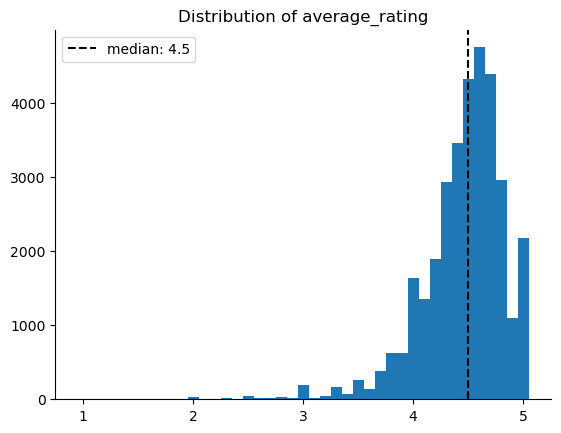

In [131]:
# Initiate figure object
plt.figure()

# Create x and y variables for plot, then plot a bar plot
x_labels = processed_df['average_rating'].sort_values().value_counts(sort = False).index
height   = processed_df['average_rating'].sort_values().value_counts(sort = False)
plt.bar(x_labels, height, width = 0.1)

# Plot a vertical line for median
plt.axvline(x = processed_df['average_rating'].median(), 
            label = f"median: {processed_df['average_rating'].median()}", 
            linestyle = '--', c = 'black')

# Plot title and show plot
plt.title('Distribution of average_rating')
plt.legend()
sns.despine()
plt.show()    

The target feature, `average_rating`, was observed to have a left skew. Furthermore there is a smaller peak at 5, possibly caused by recipes who have lesser ratings but all 5 star ratings. Overall, the skew can be explained by most recipes being acceptable, as writers with a recipe rating of less than 4 likely to stop writing recipes due to lack of acceptance from the commnuity. As the project's goal is to determine if a recipe is worth the time and effort or not, recipes with an average rating of greater than or equal to the median of 4.5 were considered worth it. Visually, this roughly splits the dataset in half, removes the skew, and changes the problem statement from a regression to a classification problem.

In [132]:
# Convert average_rating into a binary categorical column
processed_df['recipe_worth_it'] = processed_df['average_rating'].apply(lambda x: np.where(x>=4.5,1,0))

In [133]:
# Examine the distribution of the target feature using predefined function
categorical_value_count(processed_df,'recipe_worth_it')

,recipe_worth_it,Counts,% of total
0,1,19703,58.48
1,0,13988,41.52


After conversion, the new target feature, `recipe_worth_it`, has a roughly equal distribution between 'worth it'(1) and 'not worth it'(0). Furthermore, the baseline of any future modelling would be 58.48% as just blinding guessing all recipes as 'worth it' would yield an accuracy of 58.48%.

In [ ]:
# Dropping the old target feature
processed_df.drop(columns = ['average_rating'], inplace = True)

## Null Values

In [134]:
# Condition to identify only columns with null values
cond1 = processed_df.columns[processed_df.isna().any()]

# Examining the percentage of null values in each column
display(processed_df[cond1].isna().sum() / processed_df.shape[0] * 100)

number_of_reviews           0.181057
calories_kcal               1.611706
carbohydrateContent_g       1.733401
cholesterolContent_mg      18.105726
fatContent_g                3.167018
fiberContent_g              5.428750
proteinContent_g            2.291413
saturatedFatContent_g       6.455730
sodiumContent_mg            1.679974
sugarContent_g              5.838354
unsaturatedFatContent_g     1.593897
number_of_servings          0.032650
cook_time                  19.574961
prep_time                   6.298418
review                      0.181057
author                      0.002968
dtype: float64

Overall, the columns `cholesterolContent_mg` and `cook_time` have null values of greater than 15% of the column. This represents a risk as imputing would likely change the distribution of the colummns. However, just dropping these rows would lead to a loss of at least 15% of the data. Thus, the null values were further analyzed to determine possibilities for dealing with null values.

### Null Values for `number_of_reviews`

In [135]:
# Visually examine the recipes with null values
display(processed_df[processed_df['number_of_reviews'].isna()].head())

,recipe_title,recipe_title_wc,average_rating,number_of_ratings,number_of_reviews,description,description_wc,additional_description,additional_description_wc,description_flavour_text,...,cook_time,prep_time,total_time,tags,published_quarter,with_video,with_image,review,author,recipe_worth_it
683,Roasted Cauliflower Salad,3,4.5,2.0,NaN,Here's a salad that uses roasted cauliflower a...,24,['Preheat the oven to 425 degrees F (210 degre...,117,This roasted cauliflower salad features raisin...,...,15.0,10.0,30.0,cauliflower vegetable-salads salad,4.0,0.0,1.0,NaN,Bibi,1
1835,Air Fryer Smoked Salmon Wontons,5,5.0,2.0,NaN,These savory little bundles have just five ing...,44,"['Combine cream cheese, salmon, capers, and re...",269,You only need 5 ingredients for these deliciou...,...,5.0,45.0,50.0,appetizers-and-snacks,4.0,0.0,1.0,NaN,France C,1
2683,Italian Mac and Cheese,4,5.0,2.0,NaN,This dish comes together in about 45 minutes f...,22,['Bring a large pot of lightly salted water to...,209,This homemade Italian mac and cheese is made w...,...,35.0,10.0,45.0,main-dish pasta macaroni-and-cheese,4.0,0.0,1.0,NaN,thedailygourmet,1
4471,Swiss-Style Veal and Mushrooms,4,4.0,2.0,NaN,Do you wish dinner could be ready when you got...,34,"['Stir the stock, soup, thyme, veal, mushrooms...",84,Do you wish dinner could be ready when you got...,...,425.0,10.0,435.0,everyday-cooking,1.0,0.0,1.0,NaN,Campbell's Kitchen,0
5106,Whiskey Sidecar,2,5.0,2.0,NaN,A whiskey sidecar is an excellent alternative ...,13,['Place sugar in a shallow bowl. Run a lemon w...,72,This whiskey sidecar cocktail with lemon juice...,...,NaN,5.0,5.0,drinks cocktails whiskey-drinks,3.0,0.0,1.0,NaN,Cally,1


In [136]:
# Cross checking, the number of reviews with the number of ratings
processed_df[processed_df['number_of_reviews'].isna()]['number_of_ratings'].describe()

count    61.000000
mean      2.147541
std       0.477356
min       2.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       5.000000
Name: number_of_ratings, dtype: float64

The recipes with a null value for number of reviews all had 5 or less number of ratings, suggesting that these recipes do not have reviews because they were either new or not tried enough. As such, null values for `number of reviews` were filled with 0 to represent no reviews.

In [137]:
# Filling null values with 0
processed_df['number_of_reviews'].fillna(0, inplace = True)

In [138]:
# Checking if all null values were removed
print(f"Number of remaining null values for column: {processed_df['number_of_reviews'].isna().sum()}")

Number of remaining null values for column: 0


### Null Values for `number_of_servings`

In [139]:
# Condition to identify only columns with null values
cond1 = processed_df.columns[processed_df.isna().any()]

# Examining the percentage of null values in each column
display(processed_df[cond1].isna().sum() / processed_df.shape[0] * 100)

calories_kcal               1.611706
carbohydrateContent_g       1.733401
cholesterolContent_mg      18.105726
fatContent_g                3.167018
fiberContent_g              5.428750
proteinContent_g            2.291413
saturatedFatContent_g       6.455730
sodiumContent_mg            1.679974
sugarContent_g              5.838354
unsaturatedFatContent_g     1.593897
number_of_servings          0.032650
cook_time                  19.574961
prep_time                   6.298418
review                      0.181057
author                      0.002968
dtype: float64

In [140]:
processed_df[processed_df['number_of_servings'].isna()]

,recipe_title,recipe_title_wc,average_rating,number_of_ratings,number_of_reviews,description,description_wc,additional_description,additional_description_wc,description_flavour_text,...,cook_time,prep_time,total_time,tags,published_quarter,with_video,with_image,review,author,recipe_worth_it
1969,Salt Dough,2,4.5,41.0,35.0,This salt dough recipe is much like Play-Doh b...,37,['Use this salt dough recipe to make lasting t...,420,This salt dough recipe is easy to make and use...,...,120.0,20.0,160.0,more-meal-ideas diy everyday-cooking,2.0,0.0,1.0,really tasty It was fun and easy had alot of f...,IRISHEYE101,1
3131,Self-Rising Cornmeal,2,5.0,5.0,5.0,Self-rising cornmeal is easy to make at home w...,23,"['Mix cornmeal, baking powder, and salt togeth...",17,Self-rising cornmeal is easy to make using 3 s...,...,NaN,5.0,5.0,everyday-cooking,2.0,0.0,1.0,7.19.21 This recipe now makes it one less thin...,Clemmie King,1
5040,Homemade Pumpkin Spice,3,4.8,247.0,181.0,This 4-ingredient recipe for pumpkin pie spice...,55,['Skip the store-bought stuff and make homemad...,337,"Homemade pumpkin pie spice made with cinnamon,...",...,NaN,5.0,5.0,herbs-and-spices homemade-spice-blends ingredi...,3.0,1.0,1.0,"Oh my goodness, how can something that tastes ...",Jacquie,1
5550,Self-Rising Flour,2,4.9,225.0,163.0,Make your own self-rising flour when you run o...,38,"[""Looking for a homemade substitute for store-...",405,Self-rising flour is easy to make at home with...,...,NaN,5.0,5.0,more-meal-ideas diy everyday-cooking,2.0,1.0,1.0,To Much Salt!!! Add Only 1/4 tsp. of salt as o...,Marina G Roussou,1
18202,Black Garlic,2,5.0,5.0,3.0,"Black garlic has been around for many, many ye...",50,['Place a rice cooker in your garage or on an ...,89,Make black garlic at home in your rice cooker ...,...,NaN,5.0,30245.0,asian world-cuisine,2.0,0.0,1.0,Easy way to make and not have to buy so expens...,Yoly,1
23148,Panang Curry Paste,3,5.0,2.0,1.0,This Panang curry paste is worth the effort an...,50,['Place red chile peppers in a bowl and cover ...,109,Use this Panang curry paste made from scratch ...,...,5.0,25.0,30.0,sauces-and-condiments side-dish,2.0,0.0,1.0,This is excellent. I had a bit of trouble find...,Wiley,1
25900,Ornament Dough,2,4.5,107.0,88.0,Learn how to make homemade ornaments with this...,21,['Preheat the oven to 300 degrees F (150 degre...,127,Learn how to make homemade ornaments with this...,...,60.0,20.0,80.0,more-meal-ideas diy everyday-cooking,4.0,0.0,1.0,Did this with my grandkids and we loved it we ...,Darlene Coleman,1
28785,Winter Simmer Pot,3,4.8,9.0,9.0,It's been said that our sense of smell is deep...,35,['Bring 8 cups water to a boil in a large pot ...,63,"Stir up memories, warmth, and cheer with this ...",...,485.0,10.0,495.0,more-meal-ideas diy everyday-cooking,2.0,1.0,1.0,Next time I would reduce the amount of vanilla...,The Gruntled Gourmand,1
30385,Simple Chicken Brine,3,4.7,291.0,223.0,This simple chicken brine will help make the m...,13,['Pour warm water into a container that is twi...,140,Just a simple chicken brine to help make the m...,...,NaN,10.0,250.0,sauces-and-condiments brines side-dish,2.0,1.0,1.0,Thought this was really good. We are garlic nu...,Jay,1
30766,Colorful Homemade Playdough,3,4.5,76.0,65.0,This colored edible playdough is fun for kids ...,21,['Bring water to a boil in a saucepan; remove ...,81,Edible playdough is fun for kids to help make ...,...,5.0,15.0,20.0,more-meal-ideas diy everyday-cooking,2.0,0.0,1.0,Great recipe for little toddler hands!! I halv...,Stacy Child,1


As all the recipes missing number of servings were recipes to prepare ingredients for use in other recipes, such as brines and pastes, the null values were left as is and a KNN imputer was used to fill the 11 missing values later on.

### Null Values for `cook_time` and `prep_time`

In [142]:
# Conditions for null values
cond1 = processed_df['cook_time'].isna()
cond2 = processed_df['prep_time'].isna()

# Visually examine the missing columns
temp_df = processed_df[cond1 | cond2][['recipe_title', 'prep_time','cook_time','total_time']]
display(temp_df.head())

,recipe_title,prep_time,cook_time,total_time
3,Mississippi Chicken,5.0,NaN,100.0
19,Corned Beef and Cabbage,NaN,150.0,150.0
63,Cheesy Hamburger Rice Casserole,NaN,NaN,0.0
138,Scrambled Eggs in a Mug,NaN,5.0,5.0
187,Blender Hollandaise Sauce,5.0,NaN,5.0


In [143]:
print(f"Number of rows where total_time is 0: {temp_df[temp_df['total_time'] == 0].shape[0]}")
temp_df[temp_df['total_time'] == 0].head(5)

Number of rows where total_time is 0: 1937


,recipe_title,prep_time,cook_time,total_time
63,Cheesy Hamburger Rice Casserole,NaN,NaN,0.0
950,Apple-Cranberry Crostada,NaN,NaN,0.0
1140,Soft Pumpkin Cookies,NaN,NaN,0.0
1261,Spinach Ziti,NaN,NaN,0.0
1313,Fresh Tortilla Triangles,NaN,NaN,0.0


Examining the time columns, 1,937 recipes had a total_time of 0. Cross-referencing the recipe urls revealed that these recipes do not have any time elements specified within the recipe. As such, 0 values for `total_time` were replaced with null values to more accurately represent the missing data.

In [144]:
# replacing all 0 values for total_time with null values
processed_df['total_time'] = processed_df['total_time'].apply(lambda x: np.where(x==0,np.NaN,x))

Then, recipes where `total_time` is not 0 but `prep_time` and `cook_time` were null were found to belong to one of the 3 categories:
- a) the `prep_time` is equal to `total_time` leaving `cook_time` null
- b) the `cook_time` is equal to `total_time` leaving `prep_time` null
- c) other time related measures were specified, such as `cool_time`, but were not captured during the web scrape [example here](https://www.allrecipes.com/recipe/8508920/mississippi-chicken/)

For cases `a` and `b`, the missing values were filled with 0. For cases `c`, all time will be allocated to `cook time`.

In [146]:
# Filling for case a
cond1 = processed_df['prep_time'] == processed_df['total_time']
cond2 = processed_df['cook_time'].isna()

print(f"Number of values to fill:{processed_df[cond1 & cond2].shape[0]}")
print(f"Number of nulls before fill:{processed_df['cook_time'].isna().sum()}.")
processed_df.loc[cond1 & cond2,'cook_time'] = 0
print(f"Number of nulls after fill:{processed_df['cook_time'].isna().sum()}.")

Number of values to fill:2824
Number of nulls before fill:6595.
Number of nulls after fill:3771.


In [147]:
# Filling for case b
cond1 = processed_df['cook_time'] == processed_df['total_time']
cond2 = processed_df['prep_time'].isna()

print(f"Number of values to fill:{processed_df[cond1 & cond2].shape[0]}")
print(f"Number of nulls before fill:{processed_df['prep_time'].isna().sum()}.")
processed_df.loc[cond1 & cond2,'prep_time'] = 0
print(f"Number of nulls after fill:{processed_df['prep_time'].isna().sum()}.")

Number of values to fill:112
Number of nulls before fill:2122.
Number of nulls after fill:2010.


In [148]:
# Filling for case c
cond1 = processed_df['total_time'].isna() == False
cond2 = processed_df['cook_time'].isna()
cond3 = processed_df['prep_time'].isna()

# When both prep and cook time are null, set cook time = total time and prep time = 0
print(f"Number of values to fill: {processed_df[cond1 & cond2 & cond3].shape[0]}")
print(f"Number of nulls before fill:{processed_df[cond1 & cond2 & cond3]['cook_time'].isna().sum()}.")
processed_df.loc[cond1 & cond2 & cond3,'cook_time'] = processed_df.loc[cond1 & cond2 & cond3,'total_time']
processed_df.loc[cond1 & cond2 & cond3,'prep_time'] = 0
print(f"Number of nulls after fill:{processed_df[cond1 & cond2 & cond3]['cook_time'].isna().sum()}.")

Number of values to fill: 22
Number of nulls before fill:22.
Number of nulls after fill:0.


In [149]:
# When cook time is null, cook time = total time - prep time
cond1 = processed_df['total_time'].isna() == False
cond2 = processed_df['cook_time'].isna()

print(f"Number of values to fill: {processed_df[cond1 & cond2].shape[0]}")
print(f"Number of nulls before fill:{processed_df[cond1 & cond2]['cook_time'].isna().sum()}.")
processed_df.loc[cond1 & cond2,'cook_time'] = processed_df.loc[cond1 & cond2,'total_time'] - processed_df.loc[cond1 & cond2,'prep_time']
print(f"Number of nulls after fill:{processed_df[cond1 & cond2]['cook_time'].isna().sum()}.")

Number of values to fill: 1812
Number of nulls before fill:1812.
Number of nulls after fill:0.


In [150]:
# When prep time is null, prep time = total time - cook time
cond1 = processed_df['total_time'].isna() == False
cond3 = processed_df['prep_time'].isna()

print(f"Number of values to fill: {processed_df[cond1 & cond3].shape[0]}")
print(f"Number of nulls before fill:{processed_df[cond1 & cond3]['prep_time'].isna().sum()}.")
processed_df.loc[cond1 & cond3,'prep_time'] = processed_df.loc[cond1 & cond3,'total_time'] - processed_df.loc[cond1 & cond3,'cook_time']
print(f"Number of nulls after fill:{processed_df[cond1 & cond3]['prep_time'].isna().sum()}.")

Number of values to fill: 51
Number of nulls before fill:51.
Number of nulls after fill:0.


In [151]:
processed_df[['cook_time','prep_time','total_time']].isna().sum()

cook_time     1937
prep_time     1937
total_time    1937
dtype: int64

As expected, the only null values that remain are for the 1,937 recipes which had no total_time specified within the recipe.

### Null Values for `tags`

Examination of the HTML elements of the website revealed that tags and recipe title were grouped together under the same dictionary with the keys ['mainEntityOfPage' > 'breadcrumb' > 'itemListElement']. Thus, any null tags were simply filled with the recipe title.

In [153]:
# For any null tags, fill tags with title, base logic within html
cond1 = processed_df['tags'].isna()
print(f"Number of values to fill: {processed_df[cond1].shape[0]}")
print(f"Number of nulls before fill: {processed_df[cond1]['tags'].isna().sum()}")
processed_df.loc[cond1,'tags'] = processed_df.loc[cond1,'recipe_title']
print(f"Number of nulls after fill: {processed_df[cond1]['tags'].isna().sum()}")

Number of values to fill: 0
Number of nulls before fill: 0
Number of nulls after fill: 0


### Null Values for `review`

In [156]:
# Condition to identify only columns with null values
cond1 = processed_df.columns[processed_df.isna().any()]

# Examining the percentage of null values in each column
display(processed_df[cond1].isna().sum() / processed_df.shape[0] * 100)

calories_kcal               1.611706
carbohydrateContent_g       1.733401
cholesterolContent_mg      18.105726
fatContent_g                3.167018
fiberContent_g              5.428750
proteinContent_g            2.291413
saturatedFatContent_g       6.455730
sodiumContent_mg            1.679974
sugarContent_g              5.838354
unsaturatedFatContent_g     1.593897
number_of_servings          0.032650
cook_time                   5.749310
prep_time                   5.749310
total_time                  5.749310
review                      0.181057
author                      0.002968
dtype: float64

In [157]:
cond1 = processed_df['review'].isna()

print(f"{processed_df[cond1].shape[0]}")
processed_df[cond1].head()

61


,recipe_title,recipe_title_wc,average_rating,number_of_ratings,number_of_reviews,description,description_wc,additional_description,additional_description_wc,description_flavour_text,...,cook_time,prep_time,total_time,tags,published_quarter,with_video,with_image,review,author,recipe_worth_it
683,Roasted Cauliflower Salad,3,4.5,2.0,0.0,Here's a salad that uses roasted cauliflower a...,24,['Preheat the oven to 425 degrees F (210 degre...,117,This roasted cauliflower salad features raisin...,...,15.0,10.0,30.0,cauliflower vegetable-salads salad,4.0,0.0,1.0,NaN,Bibi,1
1835,Air Fryer Smoked Salmon Wontons,5,5.0,2.0,0.0,These savory little bundles have just five ing...,44,"['Combine cream cheese, salmon, capers, and re...",269,You only need 5 ingredients for these deliciou...,...,5.0,45.0,50.0,appetizers-and-snacks,4.0,0.0,1.0,NaN,France C,1
2683,Italian Mac and Cheese,4,5.0,2.0,0.0,This dish comes together in about 45 minutes f...,22,['Bring a large pot of lightly salted water to...,209,This homemade Italian mac and cheese is made w...,...,35.0,10.0,45.0,main-dish pasta macaroni-and-cheese,4.0,0.0,1.0,NaN,thedailygourmet,1
4471,Swiss-Style Veal and Mushrooms,4,4.0,2.0,0.0,Do you wish dinner could be ready when you got...,34,"['Stir the stock, soup, thyme, veal, mushrooms...",84,Do you wish dinner could be ready when you got...,...,425.0,10.0,435.0,everyday-cooking,1.0,0.0,1.0,NaN,Campbell's Kitchen,0
5106,Whiskey Sidecar,2,5.0,2.0,0.0,A whiskey sidecar is an excellent alternative ...,13,['Place sugar in a shallow bowl. Run a lemon w...,72,This whiskey sidecar cocktail with lemon juice...,...,0.0,5.0,5.0,drinks cocktails whiskey-drinks,3.0,0.0,1.0,NaN,Cally,1


There were 61 rows where review text is null because there were 0 reviews. For these cases, a placeholder 'nonereview' was used to fill the null values.

In [158]:
# Examine number of nulls to fill.
cond1 = processed_df['review'].isna()
print(f"Number of values to fill: {processed_df[cond1].shape[0]}")
print(f"Number of nulls before fill: {processed_df[cond1]['review'].isna().sum()}")

# Fill the nulls with placeholder
processed_df['review'].fillna('nonereview',inplace = True)
print(f"Number of nulls after fill: {processed_df[cond1]['review'].isna().sum()}")

Number of values to fill: 61
Number of nulls before fill: 61
Number of nulls after fill: 0


### Null Values for `author`

In [159]:
# Condition to identify only columns with null values
cond1 = processed_df.columns[processed_df.isna().any()]

# Examining the percentage of null values in each column
display(processed_df[cond1].isna().sum() / processed_df.shape[0] * 100)

calories_kcal               1.611706
carbohydrateContent_g       1.733401
cholesterolContent_mg      18.105726
fatContent_g                3.167018
fiberContent_g              5.428750
proteinContent_g            2.291413
saturatedFatContent_g       6.455730
sodiumContent_mg            1.679974
sugarContent_g              5.838354
unsaturatedFatContent_g     1.593897
number_of_servings          0.032650
cook_time                   5.749310
prep_time                   5.749310
total_time                  5.749310
author                      0.002968
dtype: float64

In [160]:
processed_df[processed_df['author'].isna()].head()

,recipe_title,recipe_title_wc,average_rating,number_of_ratings,number_of_reviews,description,description_wc,additional_description,additional_description_wc,description_flavour_text,...,cook_time,prep_time,total_time,tags,published_quarter,with_video,with_image,review,author,recipe_worth_it
126,One-Pan Tomato & Spinach Chicken Pasta,6,4.6,7.0,6.0,Our version of an Italian classic uses just on...,43,['Season the chicken as desired. Heat the oil ...,127,You only need 1 pan to cook this easy pasta di...,...,30.0,10.0,40.0,everyday-cooking,3.0,0.0,1.0,As easy as the recipe says. Came out great. Ha...,NaN,1


As only 1 recipe gad a null value for author, an assumption was made that the author is null because it was written by a staff member of allrecipes.com. As such, nulls were filled with the placeholder 'staffauthor'.

In [161]:
# Identify rows to fill
cond1 = processed_df['author'].isna()
print(f"Number of values to fill: {processed_df[cond1].shape[0]}")
print(f"Number of nulls before fill: {processed_df[cond1]['author'].isna().sum()}")

# Fill null values with placeholder
processed_df['author'].fillna('staffauthor',inplace = True)
print(f"Number of nulls after fill: {processed_df[cond1]['author'].isna().sum()}")

Number of values to fill: 1
Number of nulls before fill: 1
Number of nulls after fill: 0


### Summary of Remaining Null Values

In [162]:
# Condition to identify only columns with null values
cond1 = processed_df.columns[processed_df.isna().any()]

# Examining the percentage of null values in each column
display(processed_df[cond1].isna().sum())
display(processed_df[cond1].isna().sum() / processed_df.shape[0] * 100)

calories_kcal               543
carbohydrateContent_g       584
cholesterolContent_mg      6100
fatContent_g               1067
fiberContent_g             1829
proteinContent_g            772
saturatedFatContent_g      2175
sodiumContent_mg            566
sugarContent_g             1967
unsaturatedFatContent_g     537
number_of_servings           11
cook_time                  1937
prep_time                  1937
total_time                 1937
dtype: int64

calories_kcal               1.611706
carbohydrateContent_g       1.733401
cholesterolContent_mg      18.105726
fatContent_g                3.167018
fiberContent_g              5.428750
proteinContent_g            2.291413
saturatedFatContent_g       6.455730
sodiumContent_mg            1.679974
sugarContent_g              5.838354
unsaturatedFatContent_g     1.593897
number_of_servings          0.032650
cook_time                   5.749310
prep_time                   5.749310
total_time                  5.749310
dtype: float64

| Columns                                | Remaining null values            | Strategy for null values                                                                                                            |
|----------------------------------------|----------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| `number_of_reviews`                    | 0                                | Fill null with 0                                                                                                                    |
| `number_of_servings`                   | 11 (0.03%)                       | Leave for fill with KNN imputer                                                                                                     |
| Nutrition columns (10 columns)         | (537 - 6100) <br>(1.59% - 18.1%) | Leave for fill with KNN imputer                                                                                                     |
| `cook_time`, `prep_time`, `total_time` | 1937 (5.75%)                      | If `total_time` != 0, then fill either `cook_time` or `prep_time` up to `total_time`<br>If `total_time` == 0, fill with KNN imputer |
| `tags`                                 | 0                                | Fill with `recipe_title`                                                                                                            |
| `review`                               | 0                                | Fill with 'nonereview'                                                                                                              |
| `author`                               | 0                                | Fill with 'staffauthor'                                                                                                             |

### Removing Misrepresented Punctuation

Previous analysis showed that punctuation was not presented in a human legible manner for text data gather from the JSON dictionary. Thus, regular expression was used to replace these punctuation with nothing since punctuation would be removed during Natural Language Processing later on.

In [163]:
# Define list of column names that are text
text_columns = processed_df.select_dtypes(object).columns.tolist()

# Define punctuation to replace
punctuation = ["&#34;","&#39;", "&amp;"]
# https://stackoverflow.com/questions/49413005/replace-multiple-substrings-in-a-pandas-series-with-a-value
pattern = '|'.join(punctuation)

# Replace each of defined punctuation with nothing
for col in text_columns:
     processed_df[col] = processed_df[col].str.replace(pattern,'',regex = True)

In [164]:
print(f"Total number of processed columns: {processed_df.shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")

Total number of processed columns: 38.
Number of numeric columns: 28.
Number of text columns: 10.


In [165]:
joblib.dump(processed_df,'data/processed_df.pkl')

['data/processed_df.pkl']

## Distribution Analysis

In [166]:
# Re-examine the number of columns for each type
print(f"Total number of processed columns: {processed_df.shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")

Total number of processed columns: 38.
Number of numeric columns: 28.
Number of text columns: 10.


===== Distribution Plots for recipe_title_wc =====


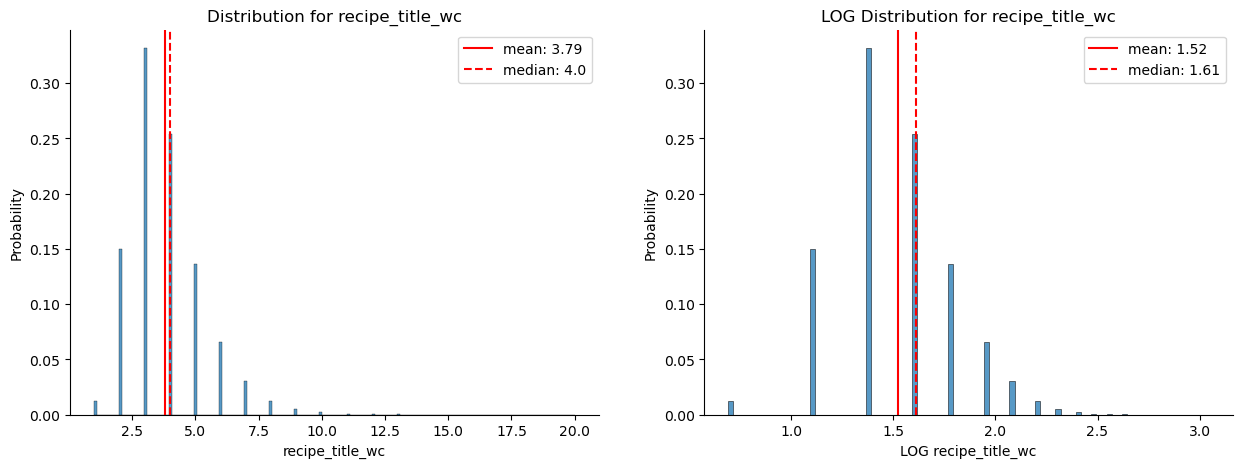

Time taken : 1.033 seconds.


===== Distribution Plots for average_rating =====


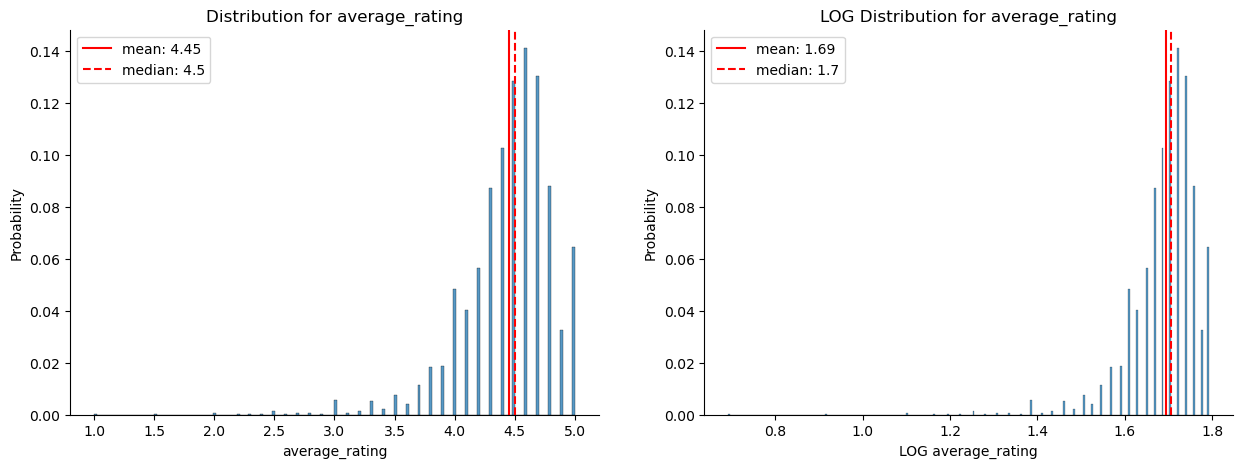

Time taken : 8.319 seconds.


===== Distribution Plots for number_of_ratings =====


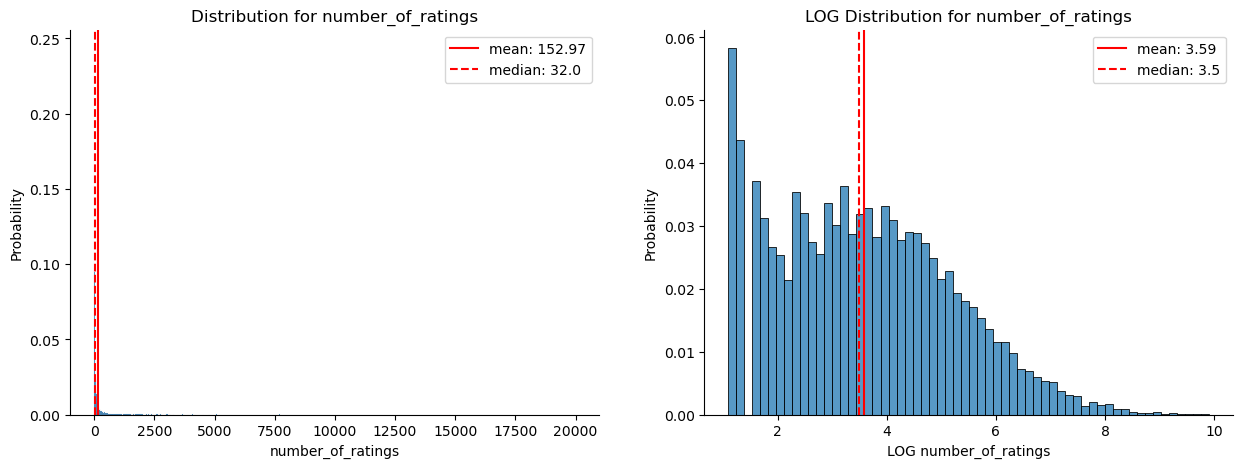

Time taken : 6.008 seconds.


===== Distribution Plots for number_of_reviews =====


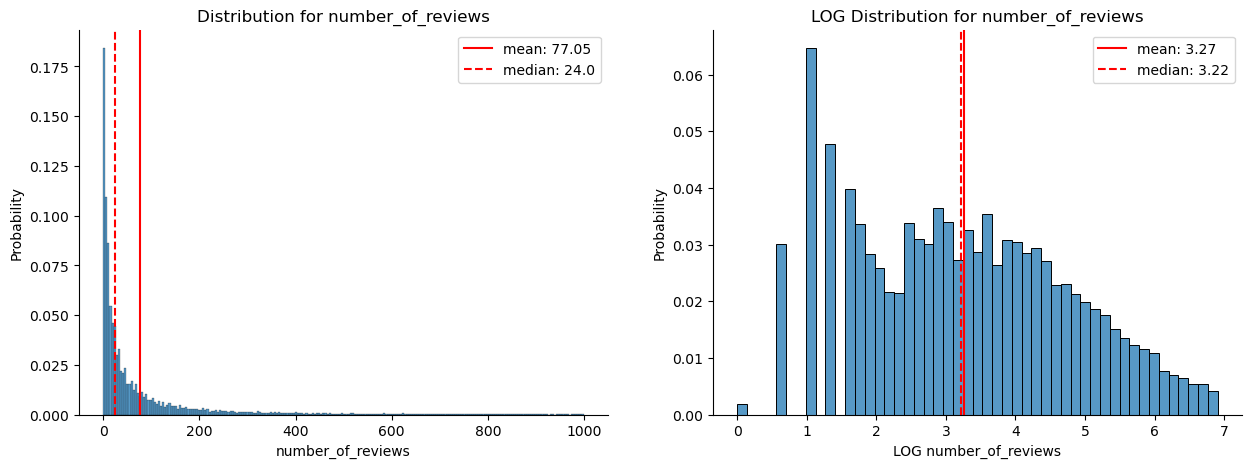

Time taken : 1.028 seconds.


===== Distribution Plots for description_wc =====


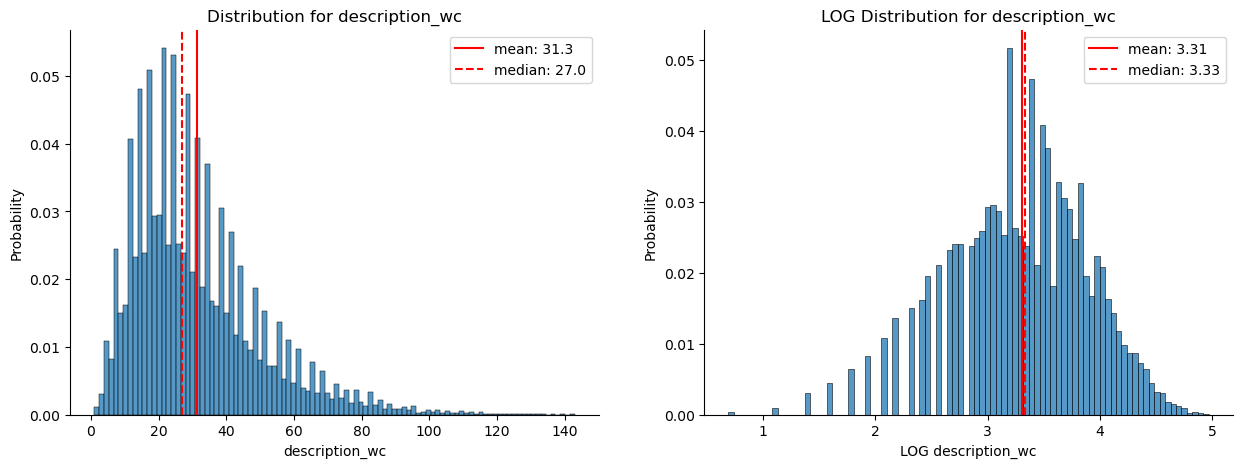

Time taken : 0.59 seconds.


===== Distribution Plots for additional_description_wc =====


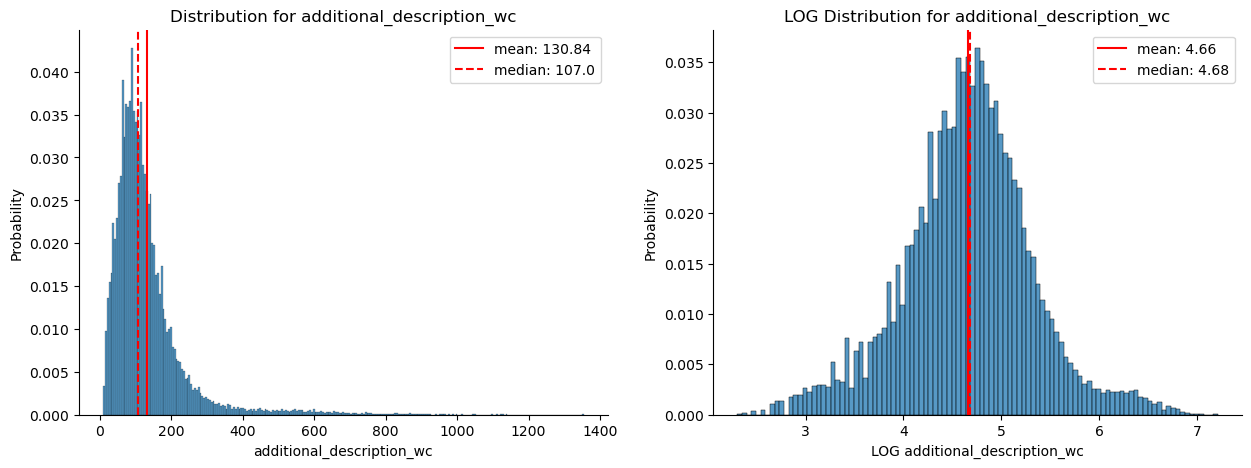

Time taken : 0.875 seconds.


===== Distribution Plots for description_flavour_text_wc =====


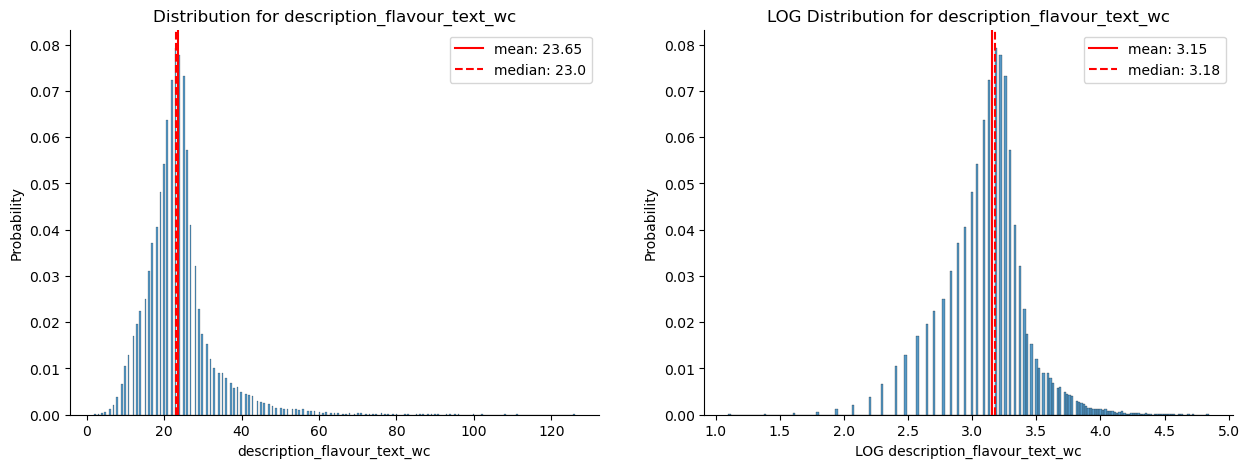

Time taken : 1.116 seconds.


===== Distribution Plots for number_of_instructions =====


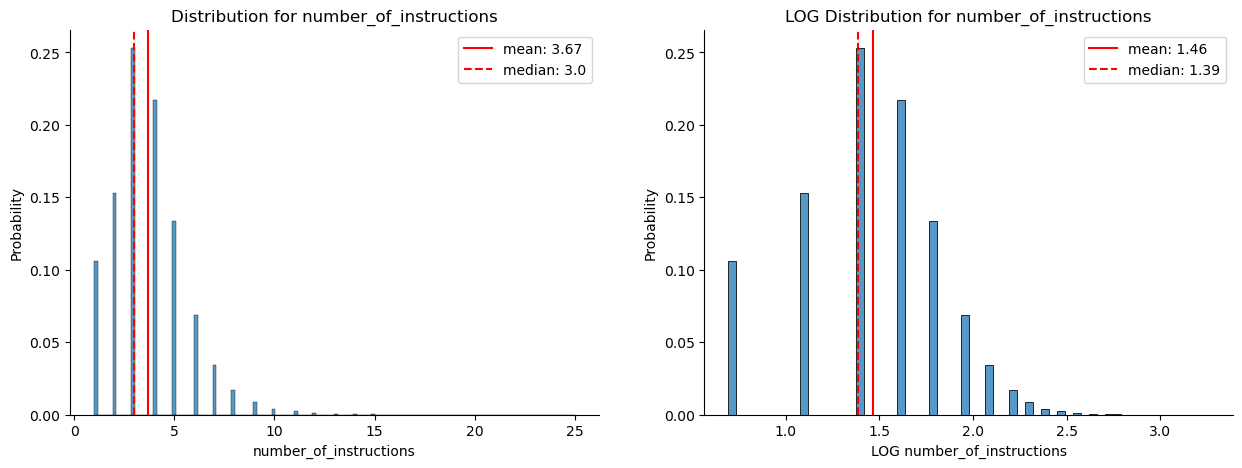

Time taken : 0.599 seconds.


===== Distribution Plots for instructions_wc =====


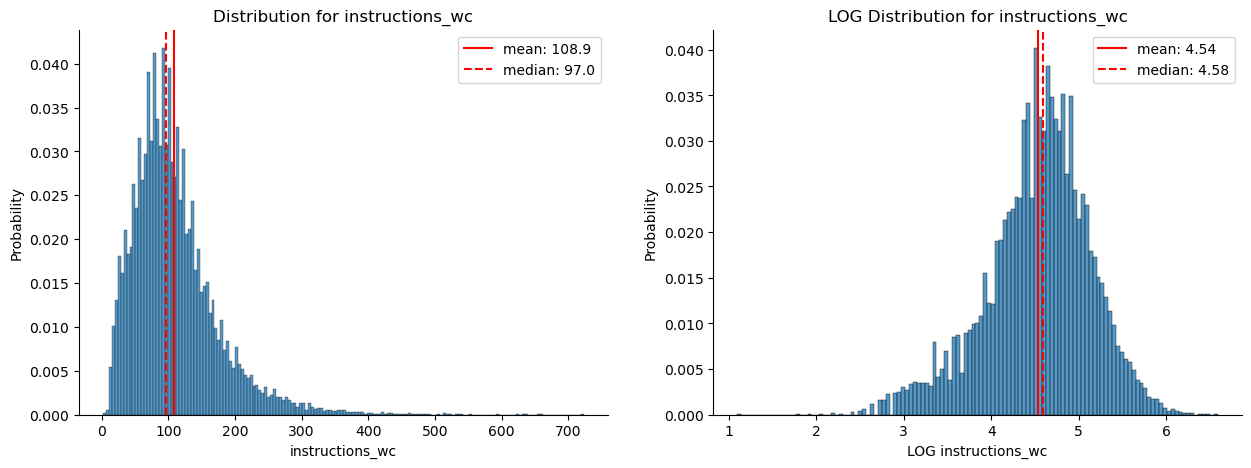

Time taken : 0.794 seconds.


===== Distribution Plots for instructions_with_image =====


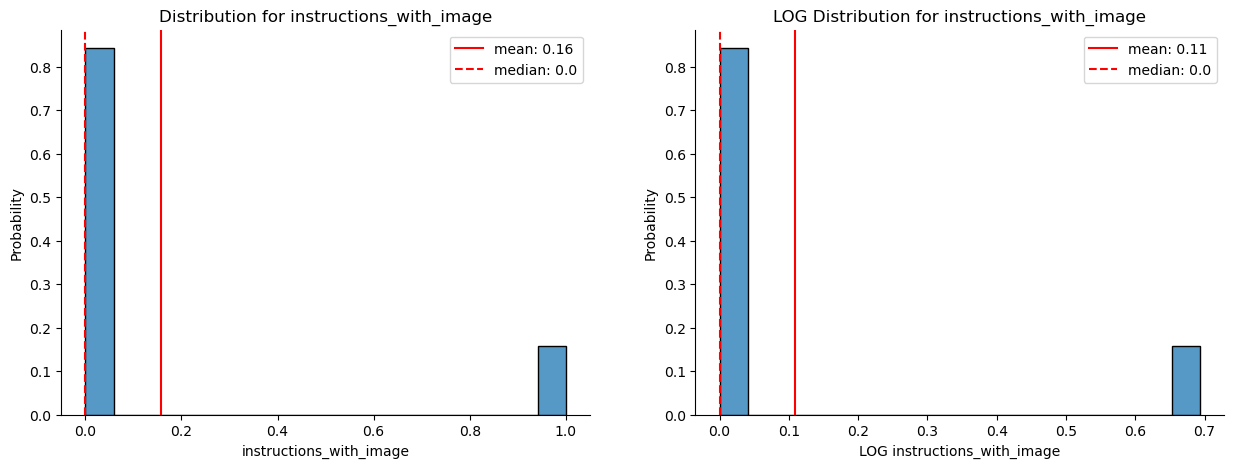

Time taken : 0.364 seconds.


===== Distribution Plots for number_of_ingredients =====


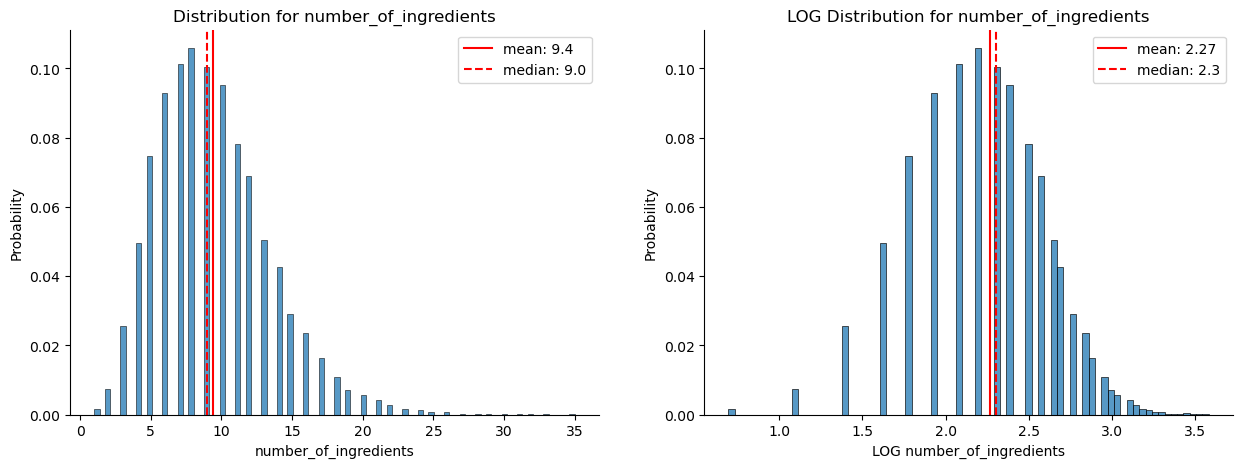

Time taken : 1.015 seconds.


===== Distribution Plots for calories_kcal =====


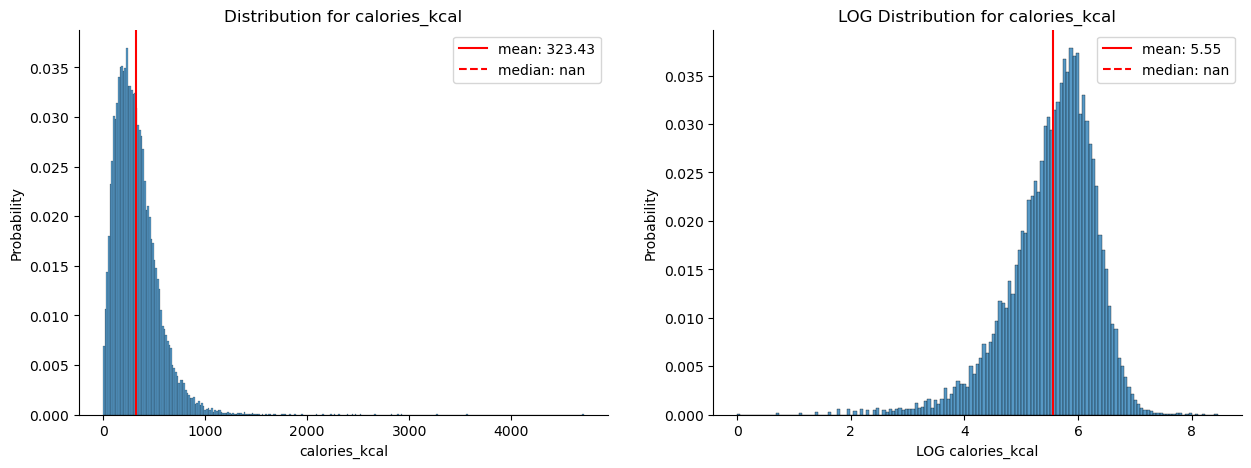

Time taken : 0.969 seconds.


===== Distribution Plots for carbohydrateContent_g =====


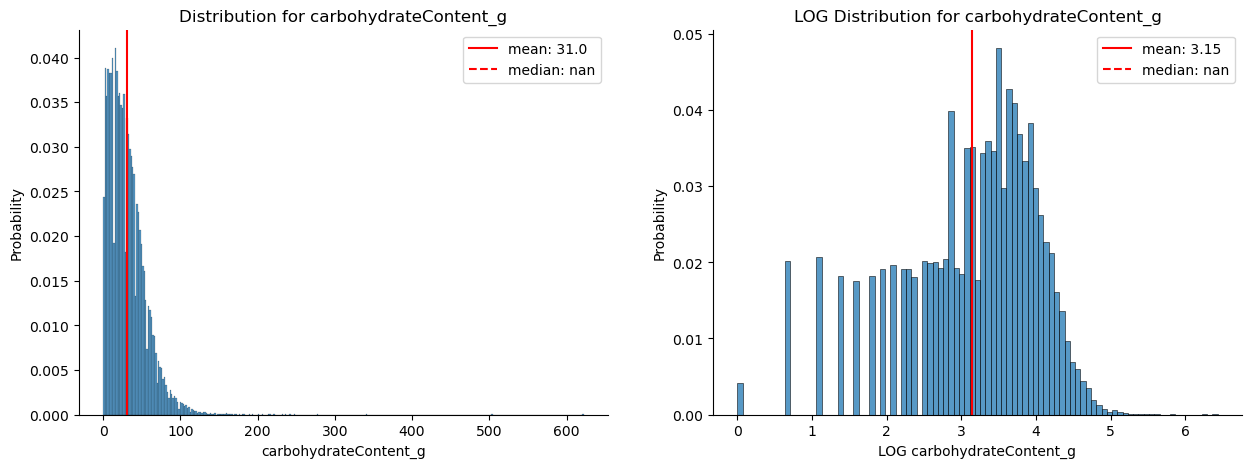

Time taken : 0.933 seconds.


===== Distribution Plots for cholesterolContent_mg =====


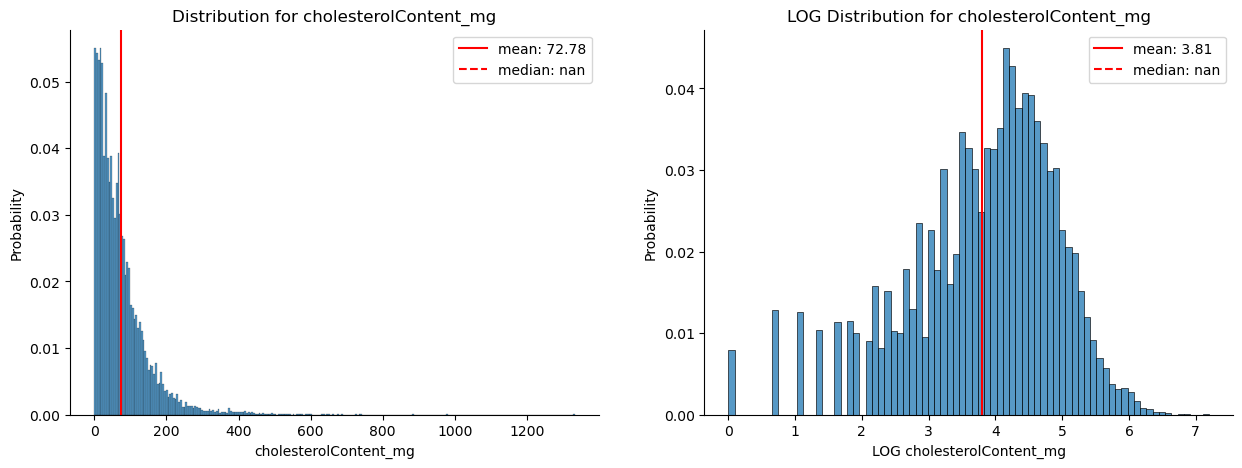

Time taken : 0.825 seconds.


===== Distribution Plots for fatContent_g =====


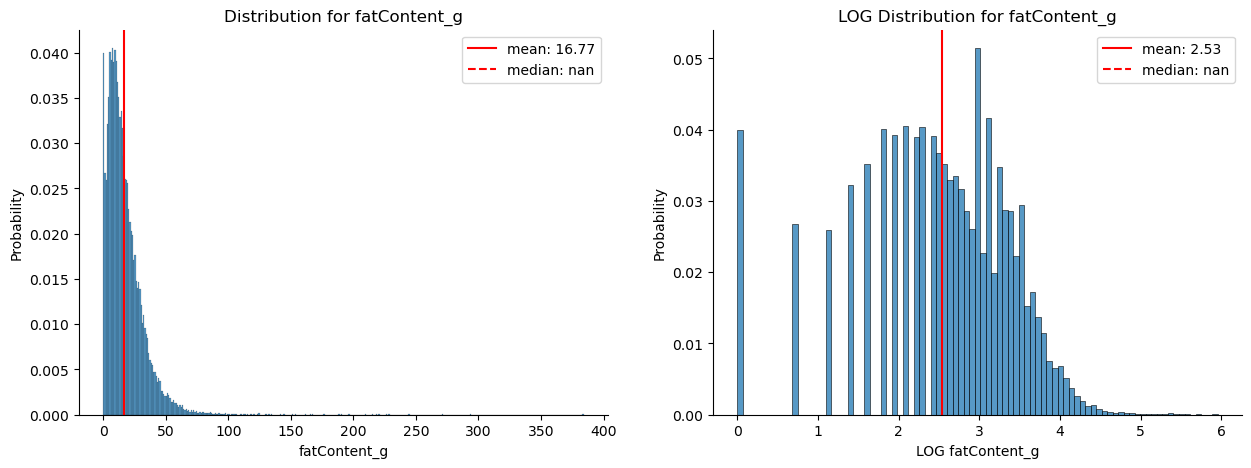

Time taken : 1.435 seconds.


===== Distribution Plots for fiberContent_g =====


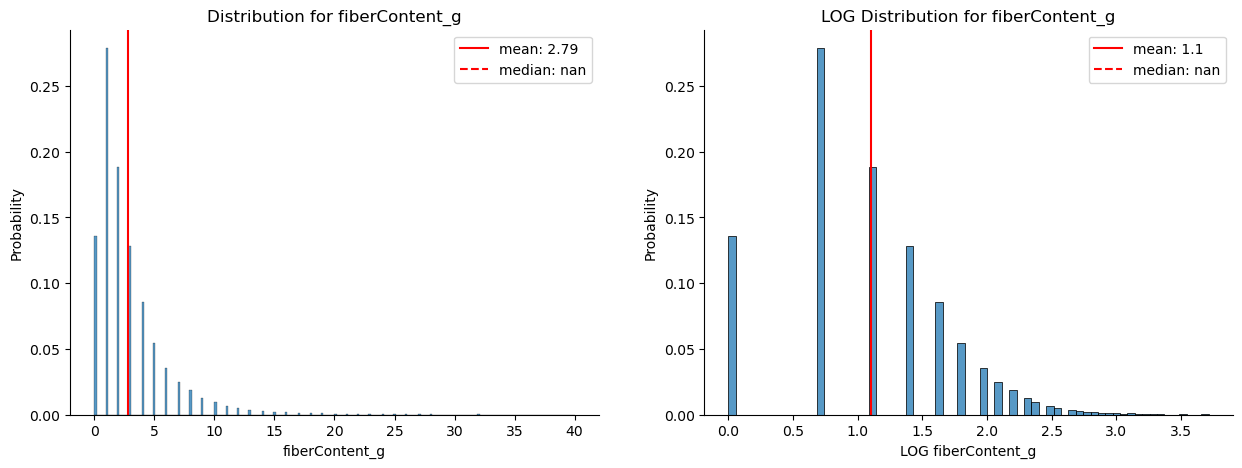

Time taken : 0.844 seconds.


===== Distribution Plots for proteinContent_g =====


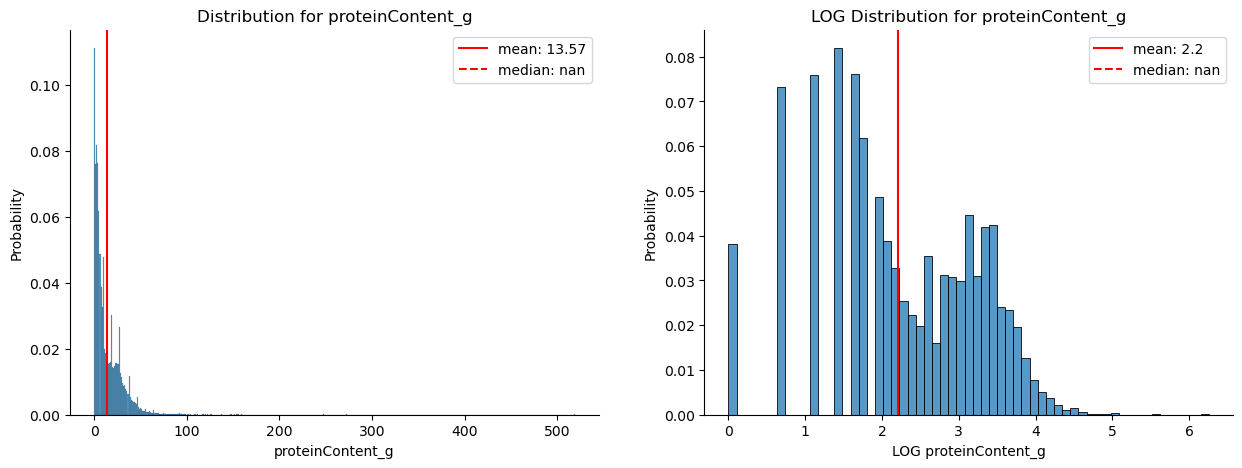

Time taken : 1.283 seconds.


===== Distribution Plots for saturatedFatContent_g =====


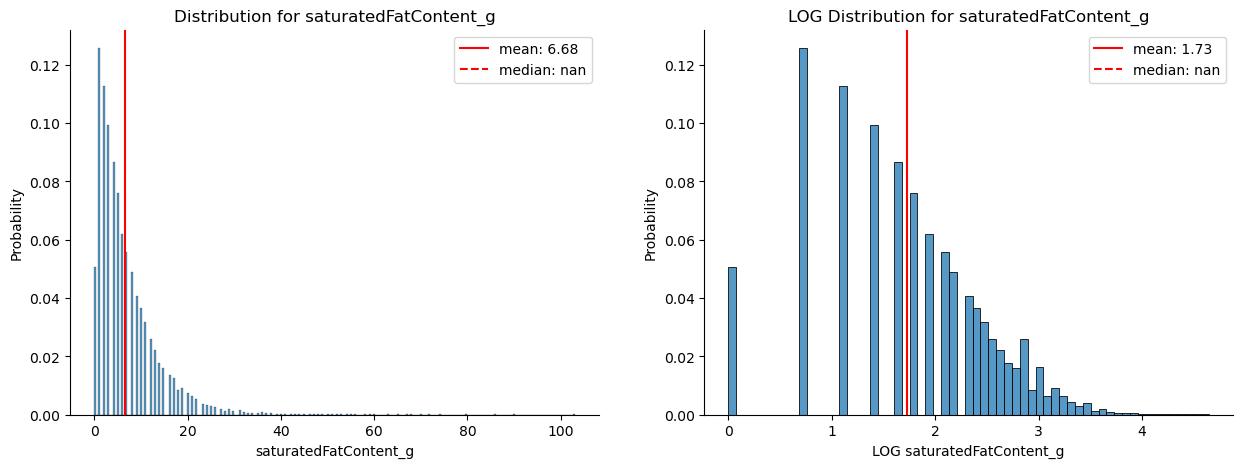

Time taken : 0.858 seconds.


===== Distribution Plots for sodiumContent_mg =====


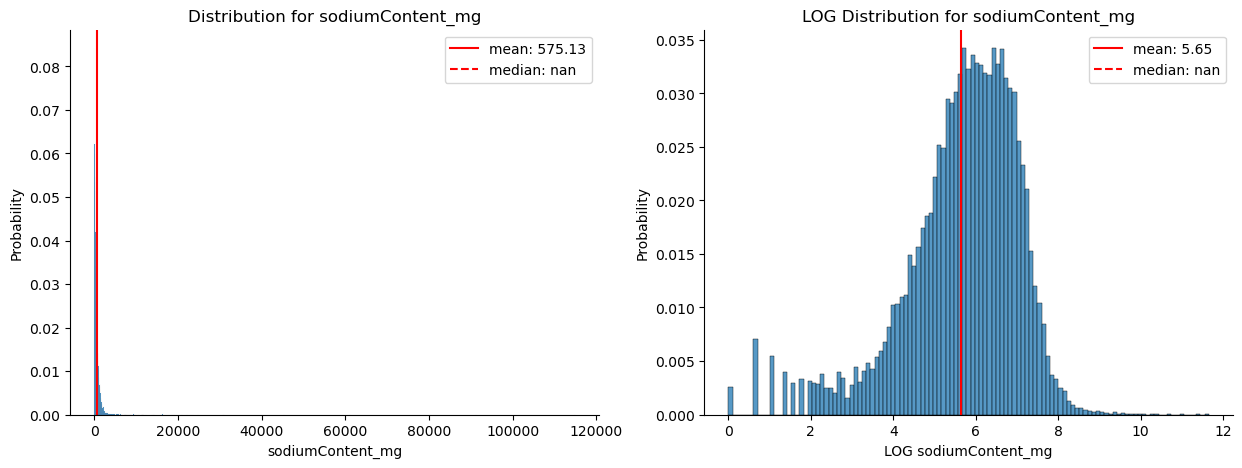

Time taken : 6.456 seconds.


===== Distribution Plots for sugarContent_g =====


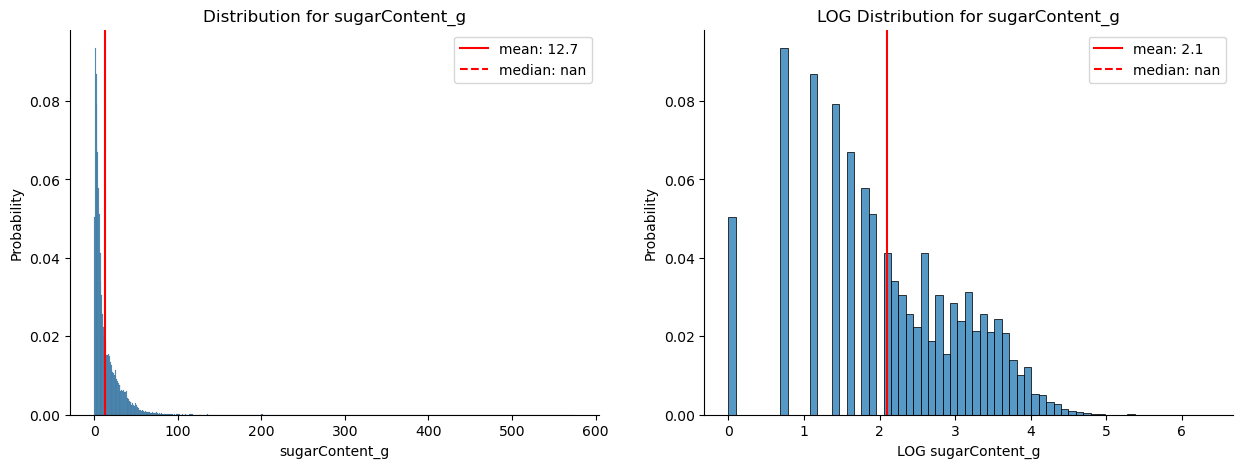

Time taken : 1.42 seconds.


===== Distribution Plots for unsaturatedFatContent_g =====


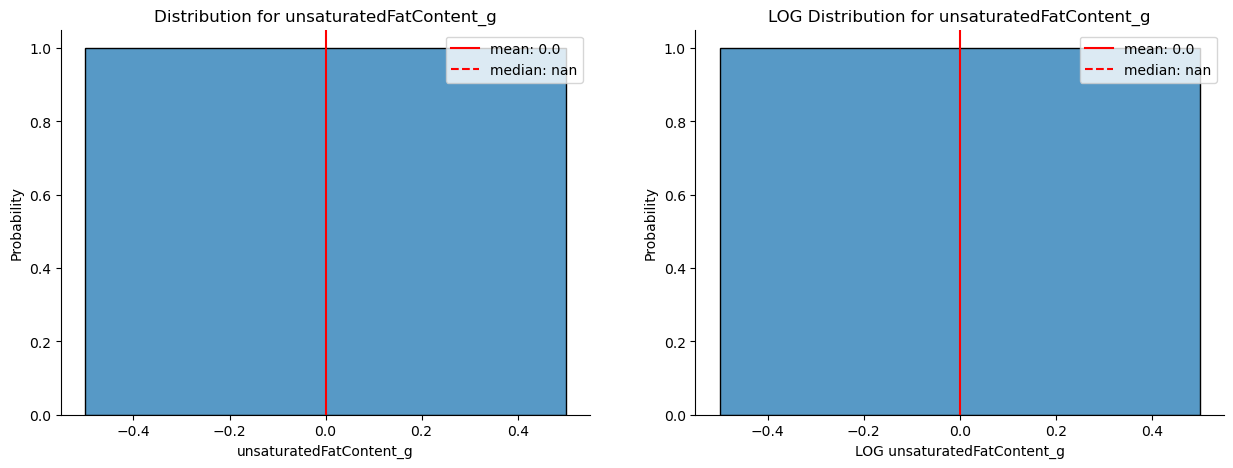

Time taken : 0.328 seconds.


===== Distribution Plots for cook_time =====


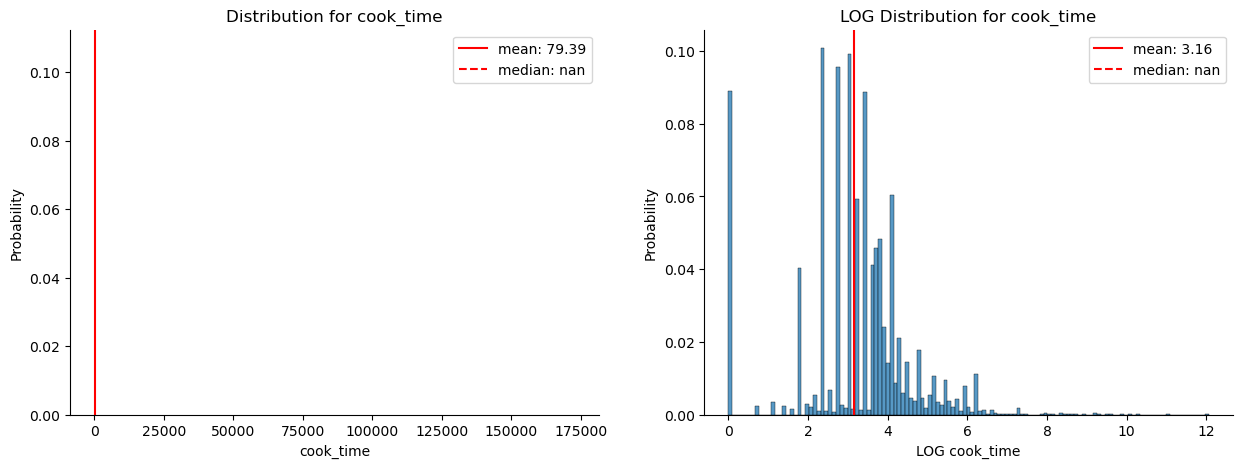

Time taken : 123.941 seconds.


===== Distribution Plots for prep_time =====


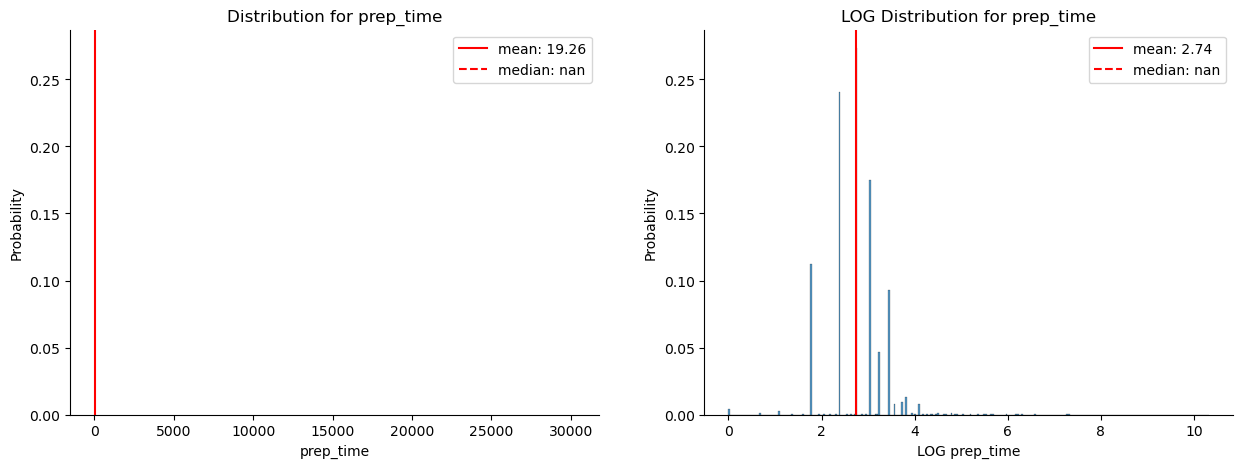

Time taken : 89.631 seconds.


===== Distribution Plots for total_time =====


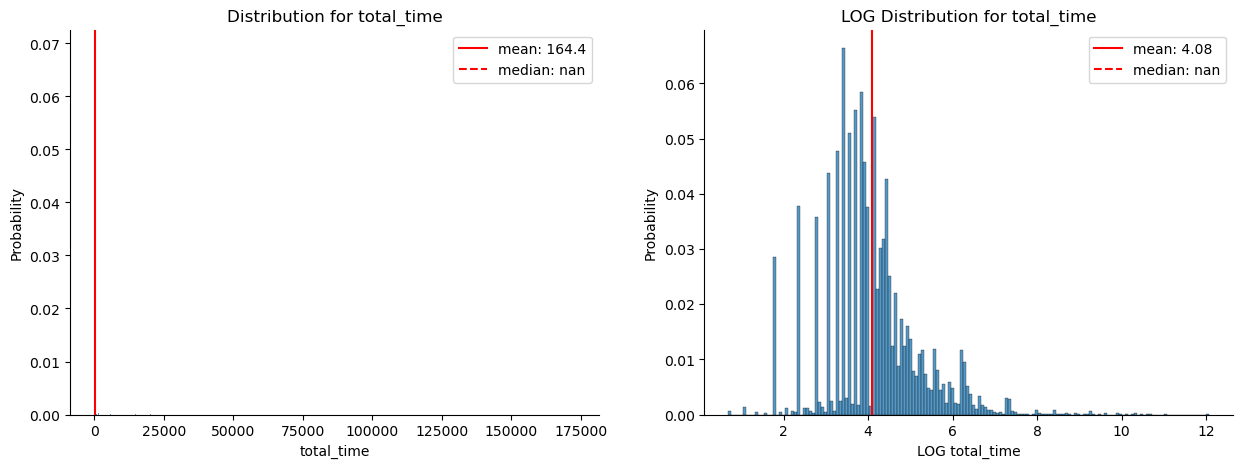

Time taken : 77.27 seconds.


===== Distribution Plots for published_quarter =====


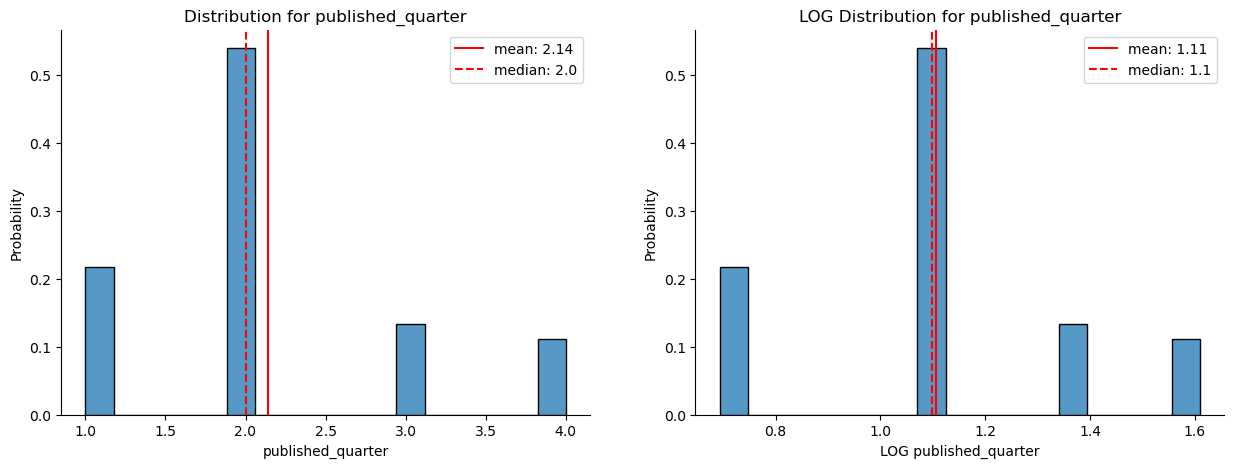

Time taken : 0.371 seconds.


===== Distribution Plots for with_video =====


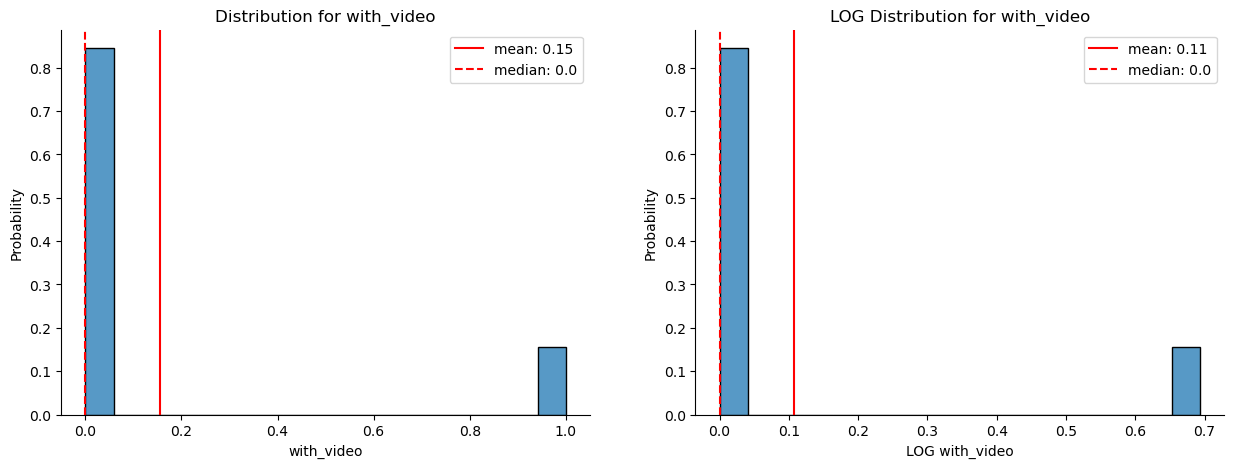

Time taken : 0.383 seconds.


===== Distribution Plots for with_image =====


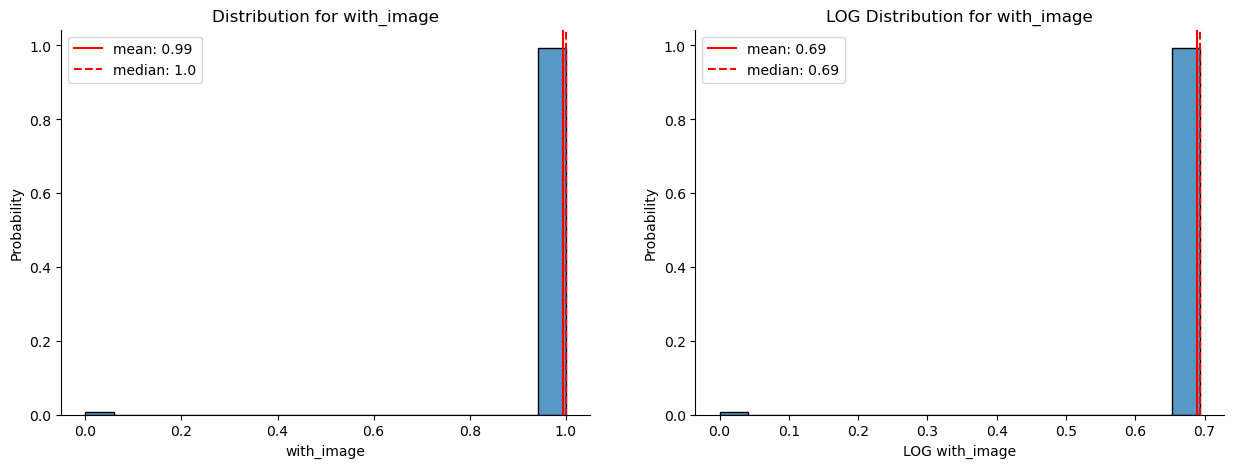

Time taken : 0.391 seconds.


===== Distribution Plots for recipe_worth_it =====


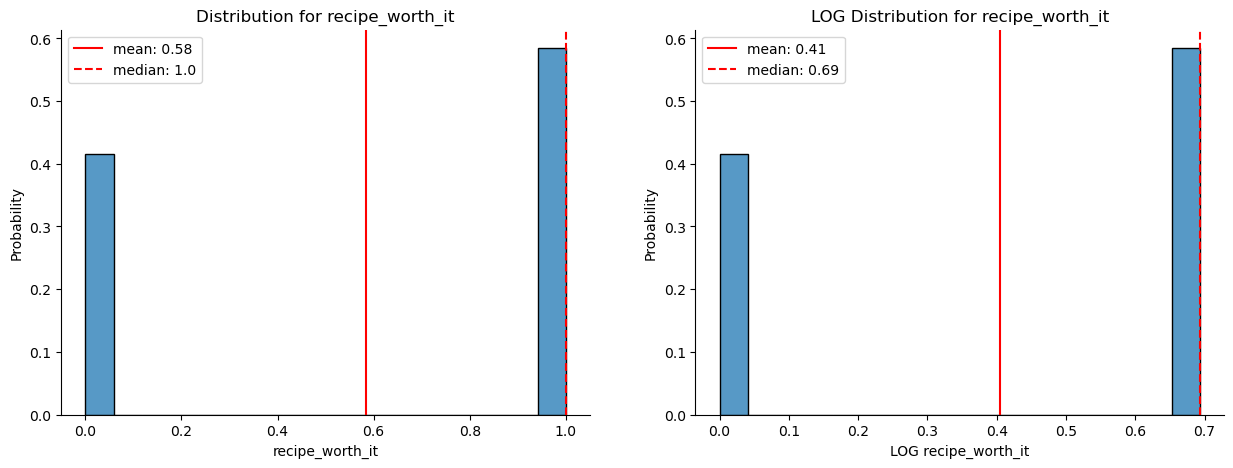

Time taken : 0.376 seconds.




In [167]:
# Plot distributions for all numerical columns
for col in processed_df.select_dtypes('number').columns.to_list():
    
    # Run predefined function for column
    plot_distribution(processed_df.select_dtypes('number'),col)

Many columns such as `number_of_review` and `proteinContent_g` were observed to have right skews. Taking the LOG of the values stretches and flattens the skew to reveal a more defined distribution. This means the original distribution of skewed sharp peaks were transformed into more 'normal' like distributions. Furthermore, some columns such as `number_of_ratings` had obvious outliers with over 20,000 ratings for the recipe. Again, taking the LOG will reduce the effect the outlier has on the modelling, and, further combined with StandarScaler will make the data suitable for regression models such as Logistic Regression and distance based models such as KNN.

The `with_image` column was 99% class 1, meaning that 99% of the recipes in the dataset have an image representing the recipe. This lack of variance makes the column useless in predicting the target variable.

The `unsaturatedFatContent_g` column was 100% filled with the value 0. Again, the lack of variance or information makes the column useless.

Thus, `with_image` and `unsaturatedFatContent_g` columns were dropped.

In [168]:
# Dropping columns with a lack of variance
processed_df.drop(columns = ['with_image', 'unsaturatedFatContent_g'], inplace = True)

In [169]:
# Examine columns available and data types after dropping the columns
print(f"Total number of columns: {processed_df.shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")

Total number of columns: 36.
Number of text columns: 10.
Number of numeric columns: 26.


## Multicollinearity Analysis

Based on distribution analysis, the outliers within the data were dealt with by taking the log of all numerical data. Multicollinearity breaks one of the assumptions behind the logistic regression model, and leads the model to be unable to identify which of the collinear features to optimize for. Furthermore, in terms of variance within the data that contributes to predicting the target, high collinearity between two features suggest a duplicate representation of the same variance by the two features. 

For this study, any two features that have a Pearson correlation coefficient greater than 0.8 or less than -0.8 were defined as being collinear. Then collinear features were further explored to determine if any of the features should be removed.

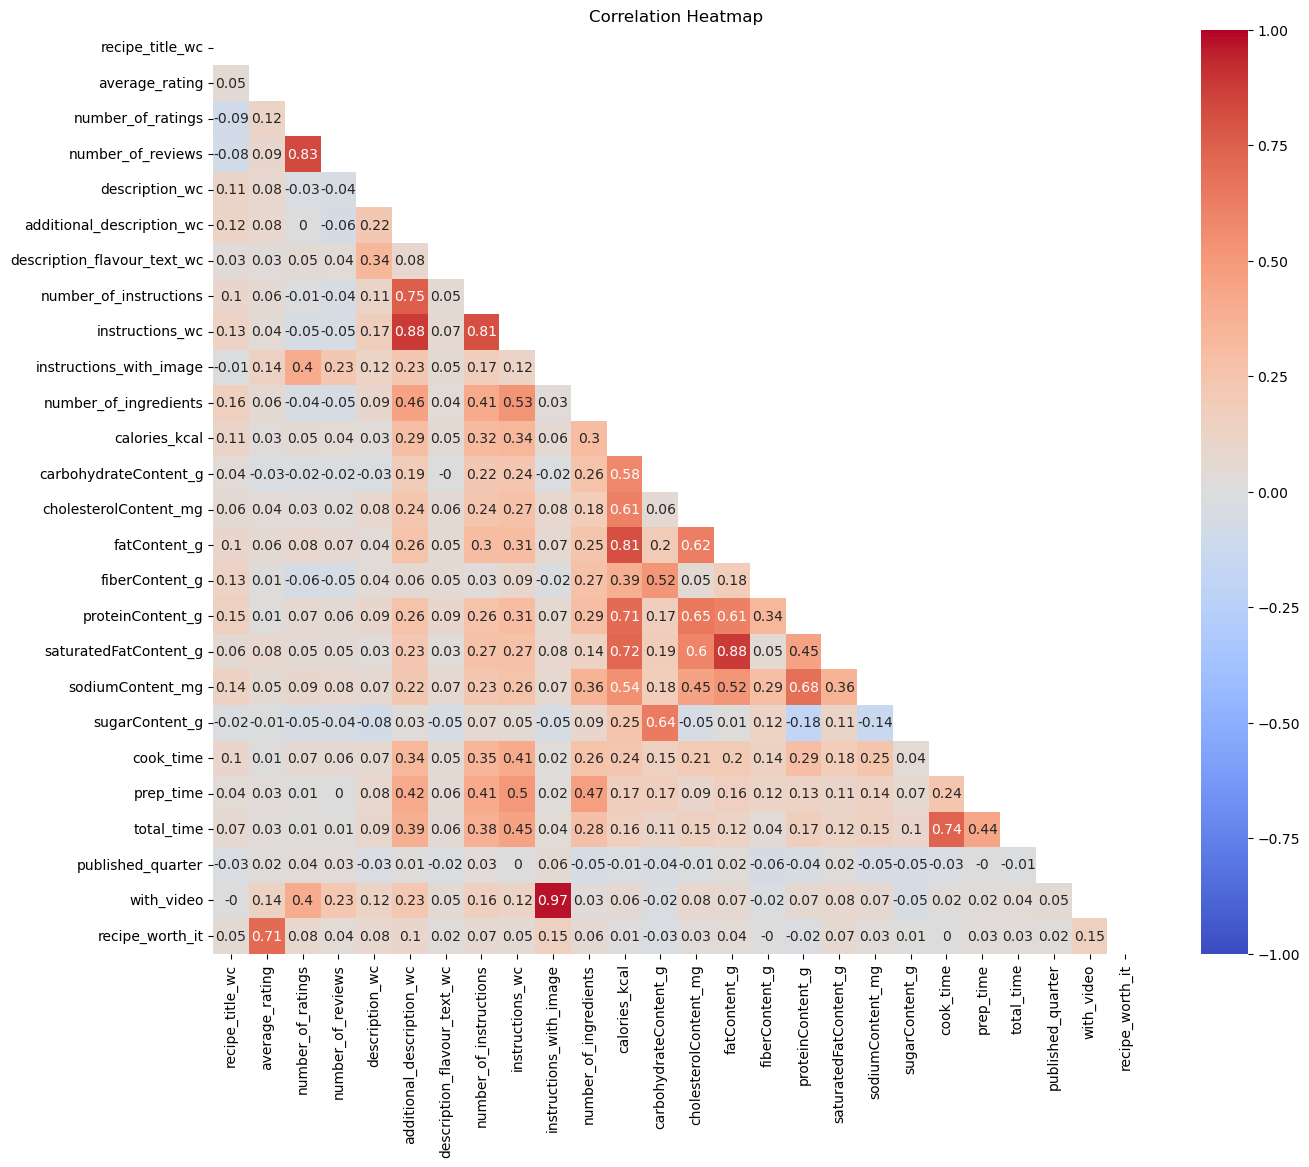

In [170]:
# create a separate DataFrame to store the log of numerical columns
mulcol_df = np.log(processed_df.select_dtypes('number')+1)

# The corr method was used to calculate correlation coefficients, the coefficients were rounded for neater display
corr_mat = np.round(mulcol_df.corr(),2)

# create a figure object
plt.figure(figsize=(15,12))

# creating mask of duplicated combinations
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# create a heatmap with min correlation of -1 and max correlation of +1
sns.heatmap(corr_mat, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)

plt.title('Correlation Heatmap ')
plt.show()

From the above heatmap, columns with correlation coefficients grater than 0.8 or less than -0.8:
- `with_video` and `instructions_with_image`: 0.97
- `calories_kcal` and `fatContent_g`: 0.81
- `fatContent_g` and `saturatedFatContent_g`: 0.88
- `instructions_wc` and `additional_description_wc`: 0.88
- `instruction_wc` and `number_of_instructions`: 0.81
- `number_of_ratings` and `number_of_reviews`: 0.83

Each of these column pairs will be examined in greater detail before decisions are made to drop the columns or transform them in feature engineering.

### `with_video` and `instructions_with_image`: 0.97

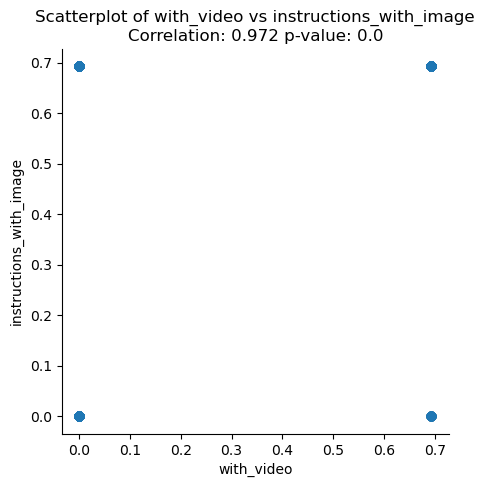

In [172]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df,'with_video', 'instructions_with_image')

Although the Pearson Correlation Coefficient is not suitable for describing binary columns, a high correlation of 0.972 suggests that recipes that have a video recording are just as likely to include images within the coooking instructions. Given that a static picture reads better with instructional text, the `with_video` column was dropped.

### `calories_kcal` and `fatContent_g`: 0.81; `fatContent_g` and `saturatedFatContent_g`: 0.88

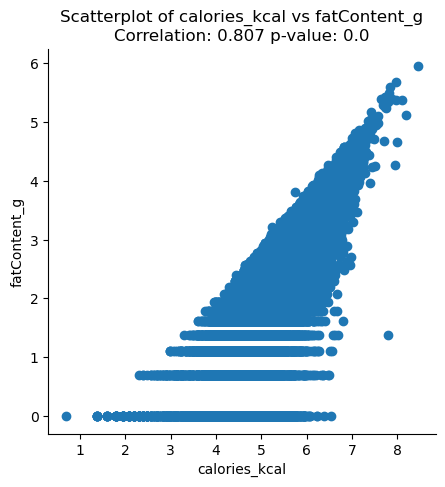

In [173]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df[['calories_kcal','fatContent_g']].dropna(), 'calories_kcal', 'fatContent_g')

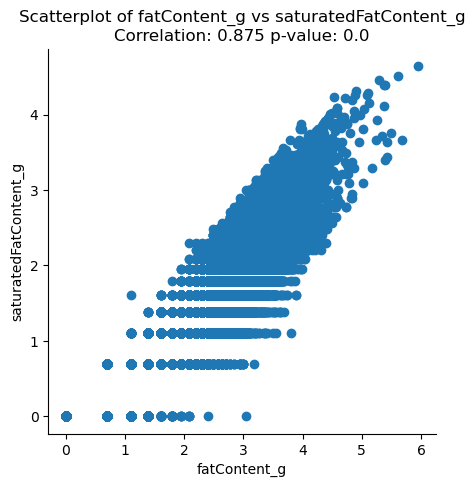

In [174]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df[['fatContent_g', 'saturatedFatContent_g']].dropna(),'fatContent_g', 'saturatedFatContent_g')

The `fatContent_g` column was observed to be correlated with both `calories_kcal` (0.807) and `saturatedFatContent` (0.875). This was expected as fat is the highest in calorie density among the other nutrients measured and a high amount of fat would correlate to higher calories. Furthermore, given that `unsaturatedFatContent` was recorded as 0g for all recipes, `saturatedFatContent` was expected to correlate highly with `fatContent` as fat is usually classified as either saturated or unsaturated fat. As the correlation between `calories_kcal` and `saturatedFatContent` was 0.72, the `fatContent` column was dropped to reduce multicollinearity.

### `instructions_wc` and `additional_description_wc`: 0.88

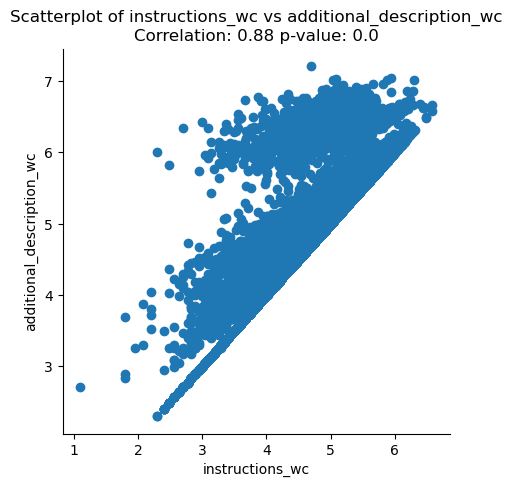

In [175]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df[['instructions_wc', 'additional_description_wc']].dropna(),'instructions_wc', 'additional_description_wc')

The scatterplot suggests 3 clusters: one is the linear line and the other two are clusters roughly centered at (3.5,4) and (5,6.5). However, there is a significant positive correlatin between `instruction_wc` and `additional_desc_wc`. However, as `instruction_wc` will be combined with `number_of_instructions` later to form a new feature, it was left inplace for now.

### `instruction_wc` and `number_of_instructions`: 0.81

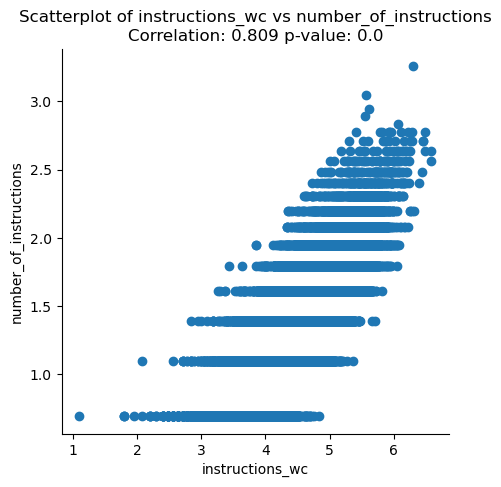

In [176]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df[['instructions_wc', 'number_of_instructions']].dropna(),'instructions_wc', 'number_of_instructions')

A correlation of 0.809 was observed between `instructions_wc` and `number_of_instructions`. One possible explanation was that the complicated recipes may require many steps with each step being complex as well. As mentioned previously, these two columns will be combined to create a new feature later on.

### `number_of_ratings` and `number_of_reviews`: 0.83

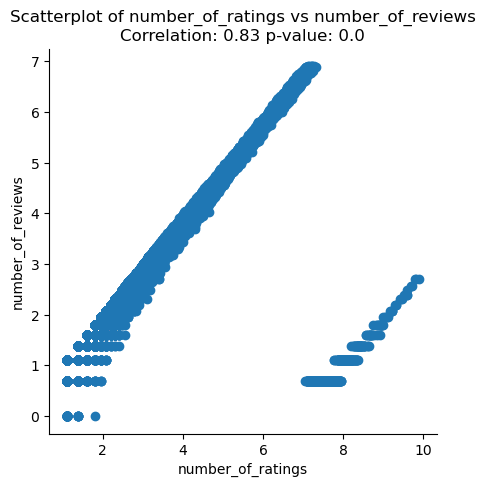

In [177]:
# Using predefined function to plot scatterplot
plot_scatterplot(mulcol_df[['number_of_ratings', 'number_of_reviews']].dropna(),'number_of_ratings', 'number_of_reviews')

The scatterplot between `number_of_ratings` and `number_of_reviews` revealed two groups of recipes with positive correlations. The first group has less ratings but a higher number of written reviews while the second group has a much higher number of ratings but a smaller number of written reviews. This observations suggests that recipes can be distinctly classified into two groups, and future studies may be performed to better understand what these tto clusters represent. For this study, the `number_of_reviews` column was dropped since there is a textual representation of written reviews in the column `reviews`.

### Dropping collinear columns that cannot be transformed

In [178]:
# Dropping columns to reduce collinearity
processed_df.drop(columns = ['with_video', 'fatContent_g', 'number_of_reviews'], inplace = True)

In [179]:
# Examine columns available and data types after dropping the columns
print(f"Total number of columns: {processed_df.shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")

Total number of columns: 33.
Number of text columns: 10.
Number of numeric columns: 23.


## Feature Engineering

In [180]:
# Create feature wc_per_instruction
processed_df['wc_per_instruction'] = processed_df['instructions_wc']/processed_df['number_of_instructions']

===== Distribution Plots for wc_per_instruction =====


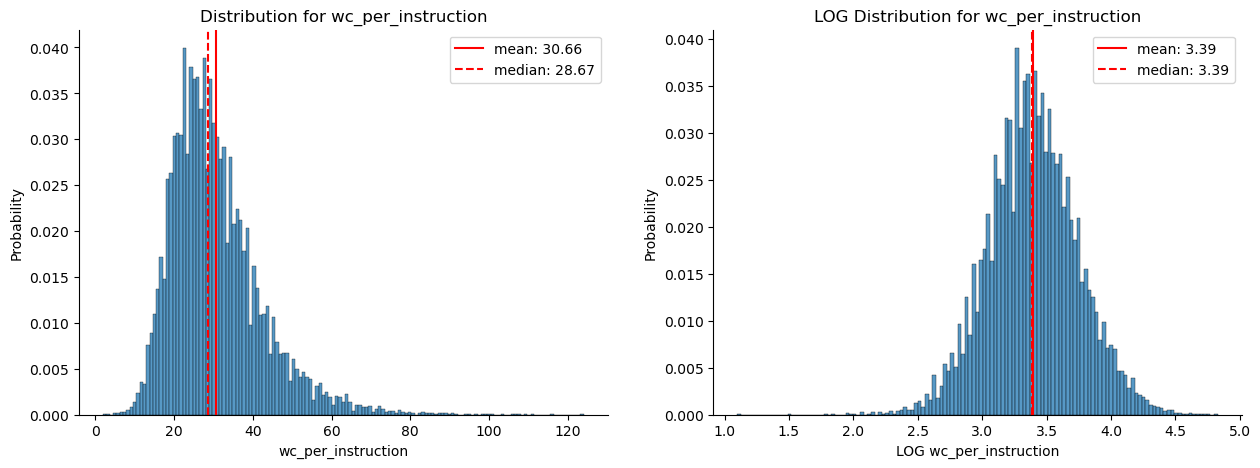

Time taken : 0.912 seconds.




In [181]:
# Examine distribution of the new feature
plot_distribution(processed_df.select_dtypes('number'), 'wc_per_instruction')

The original distribution looks like a normal distribution with a slightly right skew. Taking the LOG of the new feature brings it even closer to a normal distribution as the mean and median are equal now. As such, the new feature was kept and the columns it was derived from were dropped to prevent collinearity. 

In [182]:
# Dropping columns to reduce collinearity
processed_df.drop(columns = ['instructions_wc', 'number_of_instructions'], inplace = True)

In [183]:
# Examine columns available and data types after dropping the columns
print(f"Total number of columns: {processed_df.shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")

Total number of columns: 32.
Number of text columns: 10.
Number of numeric columns: 22.


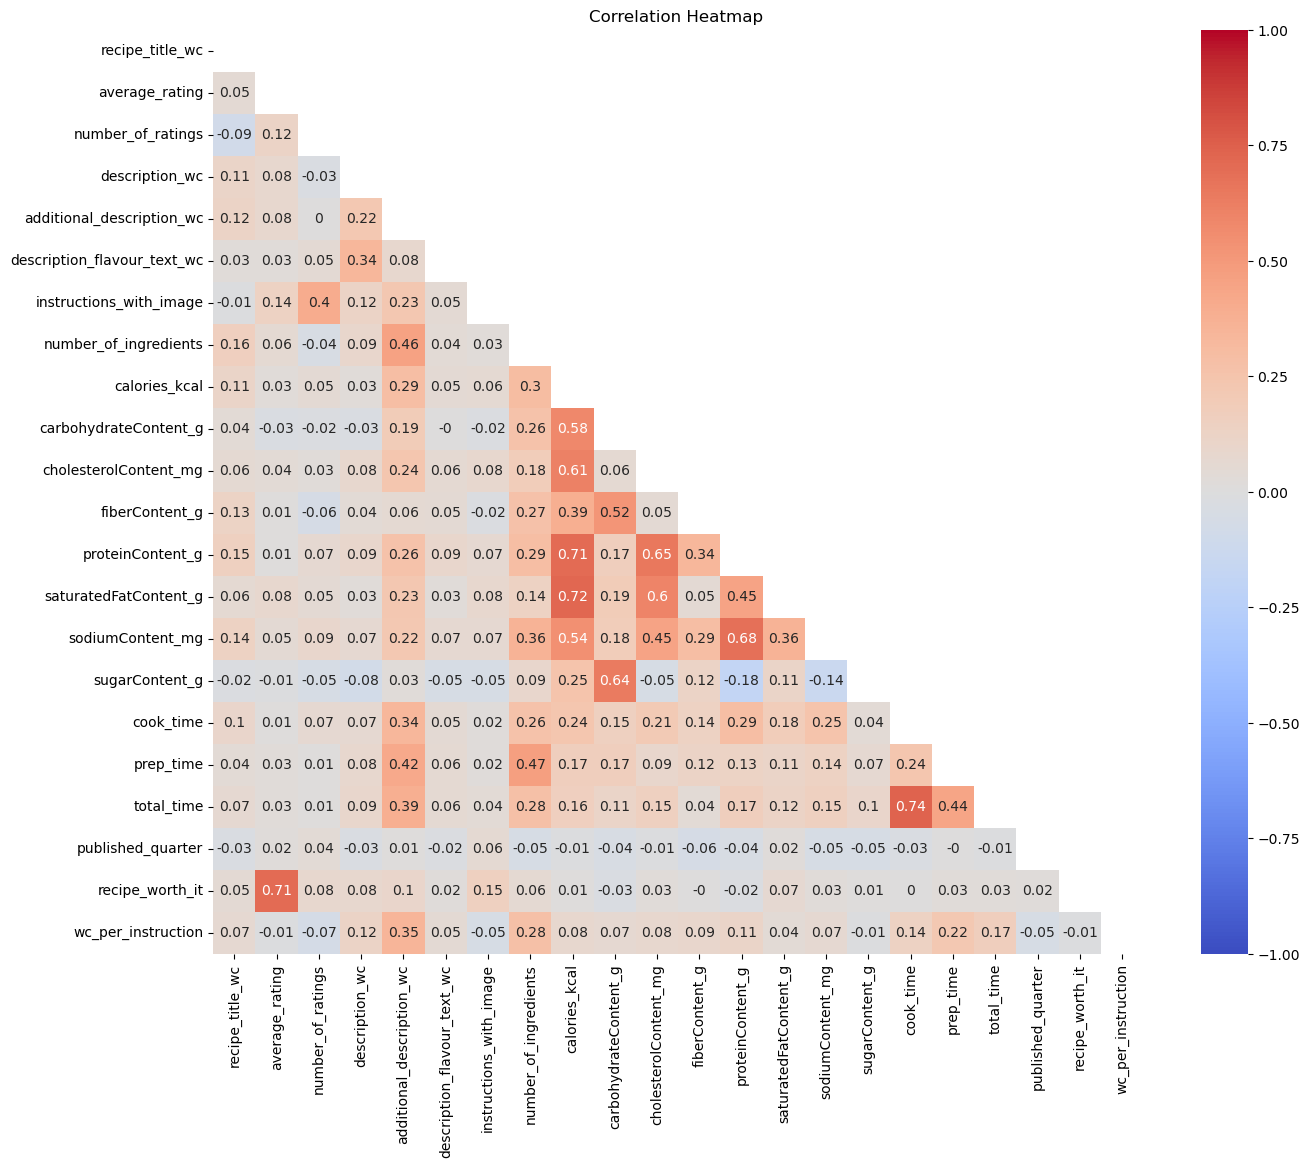

In [184]:
# Finally check for multicollinearity of the new feature
# create a separate DataFrame to store the log of numerical columns
mulcol_df = np.log(processed_df.select_dtypes('number')+1)

# The corr method was used to calculate correlation coefficients, the coefficients were rounded for neater display
corr_mat = np.round(mulcol_df.corr(),2)

# create a figure object
plt.figure(figsize=(15,12))

# creating mask of duplicated combinations
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# create a heatmap with min correlation of -1 and max correlation of +1
sns.heatmap(corr_mat, mask=mask, cmap='coolwarm', center=0, vmin=-1, vmax=1, annot=True)

plt.title('Correlation Heatmap ')
plt.show()

After dropping collinear features and generating new features, no features were observed to have a Pearson correlation coefficient of greater than 0.8 and less than -0.8. As such, the features meet the assumptions behind logistic regression and are ready for use in modelling.

## Reducing Bias towards Author

In [185]:
print(f"Number of Authors: {processed_df['author'].nunique()}, over {processed_df.shape[0]} recipes.")
categorical_value_count(processed_df, 'author').head()

Number of Authors: 19687, over 33691 recipes.


,author,Counts,% of total
0,Chef John,1116,3.31
1,Allrecipes Member,261,0.77
2,Soup Loving Nicole,228,0.68
3,Sara,194,0.58
4,Yoly,176,0.52


Given over 19,687 distinct recipe authors with the `author` Chef John having the most recipes, running a count vectorizer on this column will lead to Chef John being the main ngram generated. This can potentially lead to bias towards Chef John as the model makes a prediction based on the recipe being from Chef John or not. As such, the `author` column was removed.

In [186]:
processed_df.drop(columns = ['author'], inplace = True)

# Conclusion

In [187]:
# Examine columns available and data types after dropping the columns
print(f"Total number of columns: {processed_df.shape[1]}.")
print(f"Number of text columns: {processed_df.select_dtypes(object).shape[1]}.")
print(f"Number of numeric columns: {processed_df.select_dtypes('number').shape[1]}.")
print(f"Number of recipes: {processed_df.shape[0]}") 

Total number of columns: 31.
Number of text columns: 9.
Number of numeric columns: 22.
Number of recipes: 33691


In conclusion, the processed dataset has 33,691 recipes with 8 text features, 21 numeric features, and a binary target feature `recipe_worth_it`. The target feature was converted from a 1-5 score system into a binary feature by defining all recipes with an `average rating` of 4.5 and above as 'worth it' (1). Null values were either filled with 0 or imputed using related columns. Null values for the nutritional featurees were left as nulls for the KNN imputer later. Distribution analysis revealed columns with high skewage and outliers. The LOG of the data was taken to reduce skewage, reduce impact of outliers, and reveal more spread out distributions which were previously hidden by the skewage. Finally, multi-collinearity was examined and collinear columns were removed or engineered into new features, leading to no features having a correlation of greater than 0.8 magnitude.

# Export Processed Data

In [188]:
#Export processed_data into a pickle file 
joblib.dump(processed_df, 'data/final_processed_df.pkl')

['data/final_processed_df.pkl']

===== Distribution Plots for sodiumContent_mg =====


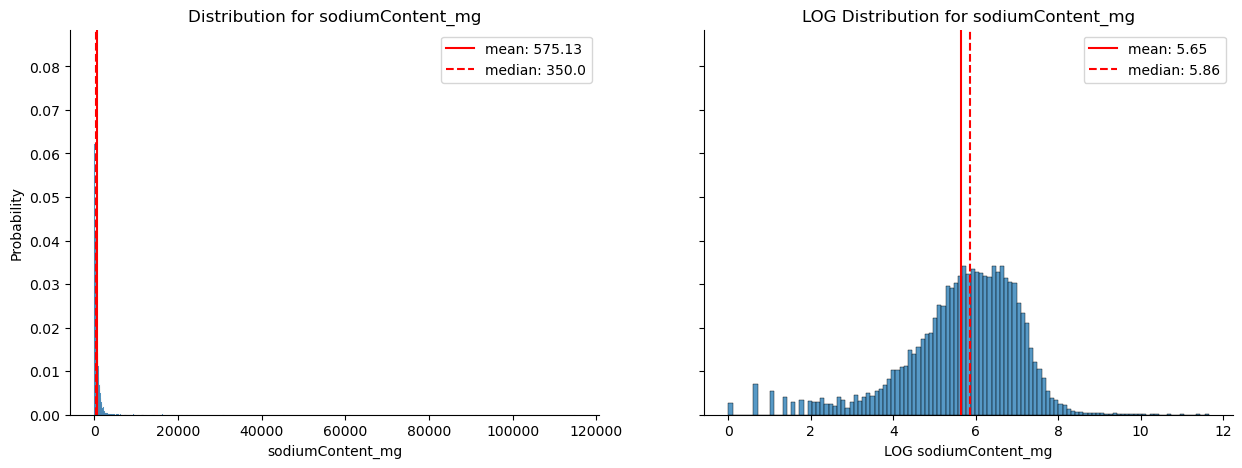

Time taken : 7.669 seconds.




In [192]:
# Extra chart for presentation purposes
df = processed_df[['sodiumContent_mg']].dropna().copy()
col = 'sodiumContent_mg'

start = time.perf_counter()
print(f"===== Distribution Plots for {col} =====")

# Create subplot object with 1 row and 2 columns
plt.subplots(1, 2, figsize = (15,5), sharey = True)

# Calculate the summary statistics for column
col_mean = np.mean(df[col])
col_median = np.median(df[col])

# Plot first histogram to show distribution as is
plt.subplot(1,2,1)
sns.histplot(data = df, x = col, stat = 'probability');
plt.axvline(col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(col_mean,2)}")
plt.axvline(col_median, linestyle = '--', c = 'red', label = f"median: {np.round(col_median,2)}")
plt.legend()
plt.title(f"Distribution for {col}")

# Plot second histogram to show log distribution
# Calculate log of column
log_df = np.log(df+1)
log_col_mean = np.mean(log_df[col])
log_col_median = np.median(log_df[col])

# Plot second histogram to show LOG distribution
plt.subplot(1,2,2)
sns.histplot(data = log_df, x = col, stat = 'probability');
plt.axvline(log_col_mean, linestyle = '-', c = 'red', label = f"mean: {np.round(log_col_mean,2)}")
plt.axvline(log_col_median, linestyle = '--', c = 'red', label = f"median: {np.round(log_col_median,2)}")
plt.xlabel(f"LOG {col}")
plt.legend()
plt.title(f"LOG Distribution for {col}")

sns.despine()
plt.savefig('images/distribution.png',dpi = 300)
plt.show()

# End timer 
end = time.perf_counter()
print(f"Time taken : {np.round(end - start,3)} seconds.")
print(f"===============================================")
print(f"")
print(f"")